In [270]:
import warnings
warnings.filterwarnings('ignore')
# % pip install pandas
# % pip install matplotlib
# % pip install numpy
# %pip install instaloader
import instaloader
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns
import numpy as np

import reelscraper as rs

# plt.style.use("seaborn-v0_8-whitegrid")
plt.style.use("fast")


from matplotlib import rc

# Set the global font to be DejaVu Sans, size 10 (or any other sans-serif font of your choice!)
rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size':11})

In [2]:
# Creating an instance of the Instaloader class
bot = instaloader.Instaloader()
# bot.login(user="Your_username",passwd="Your_password") ## Use this to log-in to your account
# NOTE signing in will probably get your account terminated/banned on instagram, so it is safest to use instaloader anonymously

### Creating SQLite database and tables

In [271]:
# create and connect to database
conn = sqlite3.connect("instagram_artists_apresearch.db")
cursor = conn.cursor()

cmd = ""

We will have 2 tables, one for the profiles and one for the posts.
Both tables will contain both human and ai content, with a column identifying which they are

In [ ]:
# create table of all profiles
# column is_human is true if profile is a human artist
cmd = """CREATE TABLE PROFILES(
    user_id INT,
    username VARCHAR(30),
    num_followers INT,
    num_posts INT,
    is_human BOOLEAN,
    PRIMARY KEY (user_id)
    );"""
cursor.execute(cmd)

# create table of all posts
cmd = """CREATE TABLE POSTS(
owner_user_id INT,
owner_username VARCHAR(30),
num_likes INT,
num_comments INT,
shortcode VARCHAR(255),
img_url VARCHAR(255),
post_date DATE,
is_reel BOOLEAN,
FOREIGN KEY(owner_user_id) REFERENCES PROFILES(user_id)
);"""
cursor.execute(cmd)

### Adding data into our sql database and tables

We will create our tables using .csv files. Files must formatted so the first row are column names and thefirst column will not contain information.

#### NOTE Only values outside of the first row and column will be added into the table

In [ ]:
def add_to_tables(csv_path, is_human_val):
    # is_human_val is whether the csv contains human or ai artist profiles

    conn = sqlite3.connect("instagram_artists_apresearch.db")
    cursor = conn.cursor()

    df = pd.read_csv(csv_path)

    start_profile = "" # empty if starting at beginning of csv else set it to what profile you need to start adding
    after_post = "" # empty if starting at beginning of profile or csv else set it to what post you want to start adding after
    past_post = len(after_post) == 0 # False if you need to only add posts after a specific post within a profile (will continue adding profiles after)
    # if past_post is False, past_profile must be False
    past_profile = past_post and (len(start_profile) == 0) # False if you need to only add profiles starting at a specific profile or post


    for i in df.index:
        for col in df.columns[1:]:
            curr_post = None
            curr_profile = None
            try:
                if(pd.notna(df.loc[i,col])):
                    curr_profile = df.loc[i,col]
                    print(curr_profile)
                    ## used to start adding profiles at a profile or post (profile inclusive, post exclusive)
                    if(curr_profile == start_profile):
                        past_profile = True
                    
                    if(past_profile):
                        p = instaloader.Profile.from_username(bot.context, df.loc[i,col]) # grab profile from instagram
                        print(f"{p.userid}, {p.username}, {p.followers}, {p.mediacount}, {is_human_val}, {df.iloc[i,0]}") # track current profile

                        # check if profile does not already exist in table
                        cursor.execute("SELECT 1 FROM PROFILES WHERE USER_ID = {}".format(p.userid))
                        existing_row = cursor.fetchone()

                        if not existing_row:
                            # insert the row
                            cmd= """INSERT INTO PROFILES(USER_ID, USERNAME, NUM_FOLLOWERS, NUM_POSTS, IS_HUMAN, GENRE) 
                                    VALUES ({}, "{}", {}, {}, {}, "{}");""".format(
                                        p.userid, p.username, p.followers, p.mediacount, is_human_val, df.iloc[i,0]
                                    )
                            cursor.execute(cmd)
                        
                        # add all posts from profile's main feed
                        # this includes reels, but we will edit this later
                        for post in p.get_posts():
                            if(past_post):
                                curr_post = post.shortcode + " on main" # keep track of current post which was added
                                cmd= """INSERT INTO POSTS(OWNER_USER_ID, OWNER_USERNAME, NUM_LIKES, NUM_COMMENTS, SHORTCODE, POST_DATE, IS_REEL, IS_HUMAN) 
                                        VALUES ({}, "{}", {}, {}, "{}", "{}", {}, {});""".format(
                                            post.owner_id, post.owner_username, post.likes, post.comments, post.shortcode, post.date_utc, False, is_human_val
                                        ) # is_reel column is set to False regardless if it is a reel or not
                                cursor.execute(cmd)
                            ## used to start adding after a specific post (post exclusive). this post should already be included in the table
                            ## uses post shortcode as identifier
                            # if (post.shortcode == after_post):
                            #     past_post = True
                        
                        # add all reels from a profile's reel tab
                        for reel in rs.from_user_get_reels(df.loc[i,col]):
                            if(past_post):
                                # check if reel was already added via main feed
                                cmd= """SELECT EXISTS(SELECT 1 FROM POSTS WHERE shortcode = "{}")""".format(reel)
                                cursor.execute(cmd)
                                exists = cursor.fetchone()[0]

                                if(exists):
                                    # if it was already added, set the is_reel value to True
                                    cmd= """UPDATE POSTS
                                            SET IS_REEL = TRUE
                                            WHERE shortcode = '{}'""".format(reel)
                                else:
                                    # grab reel data from instagram
                                    post = instaloader.Post.from_shortcode(bot.context, reel)
                                    cmd= """INSERT OR IGNORE INTO POSTS(OWNER_USER_ID, OWNER_USERNAME, NUM_LIKES, NUM_COMMENTS, SHORTCODE, POST_DATE, IS_REEL, IS_HUMAN) 
                                            VALUES ({}, "{}", {}, {}, "{}", "{}", {}, {});""".format(
                                                post.owner_id, post.owner_username, post.likes, post.comments, post.shortcode, post.date_utc, True, is_human_val
                                            ) # is_reel value is True
                                cursor.execute(cmd)
                                curr_post = reel + " on reels"
                            # if (reel == after_post):
                            #     past_post = True
                        conn.commit() # commit data after every profile
                                
            # exception handling mainly for profiles not found, faulty networks connections, or instagram blocking us temporarily
            # this helps keep track of and continue where we left off, which is why we have the past_profile and past_post
            except Exception as e:
                conn.commit()
                conn.close()
                print(f"Error with {df.loc[i,col]}, after {curr_post} : {e}")
                return
    # IMPORTANT finally save all changes to database, changes are not committed every insert
    # conn.commit()
    conn.close()

In [ ]:
add_to_tables("HA.csv", True) # add human profiles and posts into tables

In [ ]:
add_to_tables("AIA.csv", False) # add AI profiles and posts into tables

In [ ]:
# cmd= """SELECT POSTS.*
#         FROM POSTS
#         JOIN PROFILES ON POSTS.owner_user_id = PROFILES.user_id
#         WHERE PROFILES.num_followers > 50000;
#         """
# posts_df = pd.read_sql(cmd, conn)
# posts_df['post_date'] = pd.to_datetime(posts_df['post_date'])

In [272]:
cmd= """SELECT POSTS.*
        FROM POSTS
        """
posts_df = pd.read_sql(cmd, conn)
posts_df['post_date'] = pd.to_datetime(posts_df['post_date'])

In [273]:
cmd= """SELECT PROFILES.*
        FROM PROFILES
        """
profiles_df = pd.read_sql(cmd, conn)

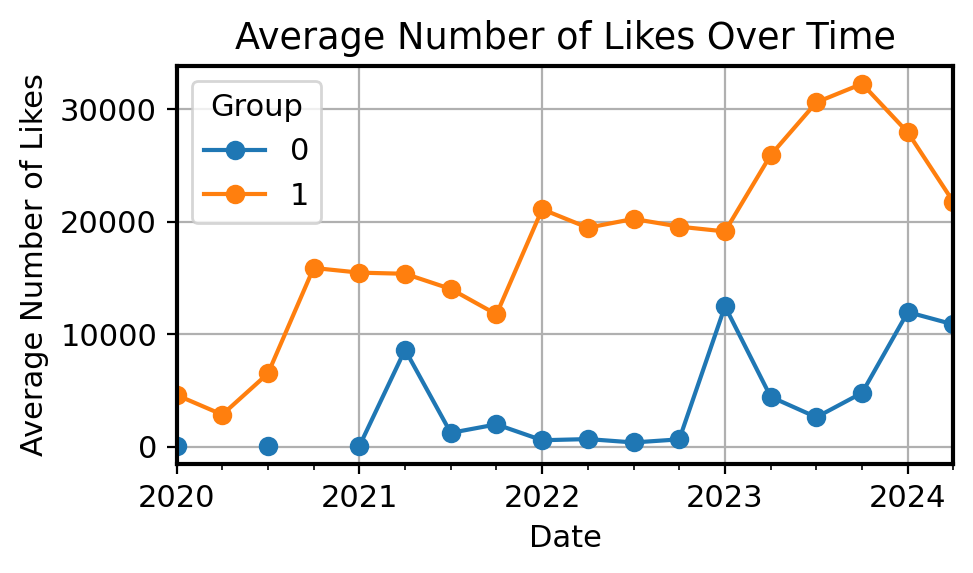

In [274]:
filtered_df = posts_df[(posts_df['num_likes'] >= 0) & (posts_df['is_reel'] == 1) & (posts_df['post_date'] >= "2020-01-01")]

date_freq = "3M"
# Calculate average likes per group and date
avg_likes = filtered_df.groupby(['is_human', pd.Grouper(key='post_date', freq=date_freq)])['num_likes'].mean().reset_index()
# avg_likes = filtered_df.groupby(["owner_username", pd.Grouper(key='owner_username')])['num_likes'].mean().reset_index()

# Pivot the data for easier plotting
pivot_df = avg_likes.pivot(index='post_date', columns='is_human', values='num_likes')

# Plotting
pivot_df.plot(kind='line', marker='o', figsize=(5, 3))
plt.title('Average Number of Likes Over Time')
plt.xlabel('Date')
plt.ylabel('Average Number of Likes')
plt.grid(True)
plt.legend(title='Group')
plt.tight_layout()
plt.show()

<Axes: >

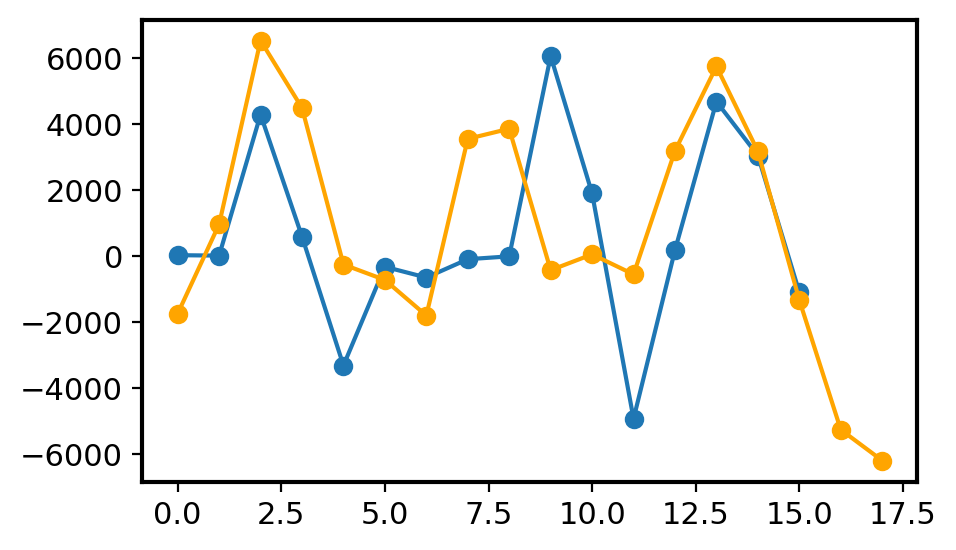

In [275]:
f = avg_likes[avg_likes["is_human"] == 0].reset_index()
dfdx = np.gradient(f["num_likes"], f.index)
# dfdx
pd.Series(dfdx).plot(kind='line', marker='o', figsize=(5, 3))

f2 = avg_likes[avg_likes["is_human"] == 1].reset_index()
df2dx = np.gradient(f2["num_likes"], f2.index)
# dfdx
pd.Series(df2dx).plot(kind='line', marker='o', figsize=(5, 3), color='orange')

In [276]:
pd.Series(df2dx).corr(pd.Series(dfdx))

0.46905013898546266

['alpha2']

                    Breakpoint Regression Results                     
No. Observations                       16
No. Model Parameters                    4
Degrees of Freedom                     12
Res. Sum of Squares           1.67239e+08
Total Sum of Squares          3.12285e+08
R Squared                        0.464466
Adjusted R Squared               0.269726
Converged:                           True
                    Estimate      Std Err            t        P>|t|       [0.025       0.975]
----------------------------------------------------------------------------------------------------
const                 602.45     1.96e+03      0.30789         0.763      -3660.9       4865.8
alpha1               330.972     2.77e+02        1.196         0.255      -271.95        933.9
beta1                2710.34     2.65e+03       1.0211             -      -3072.7       8493.4
breakpoint1          12.5368          1.8            -             -       8.6062       16.467
------

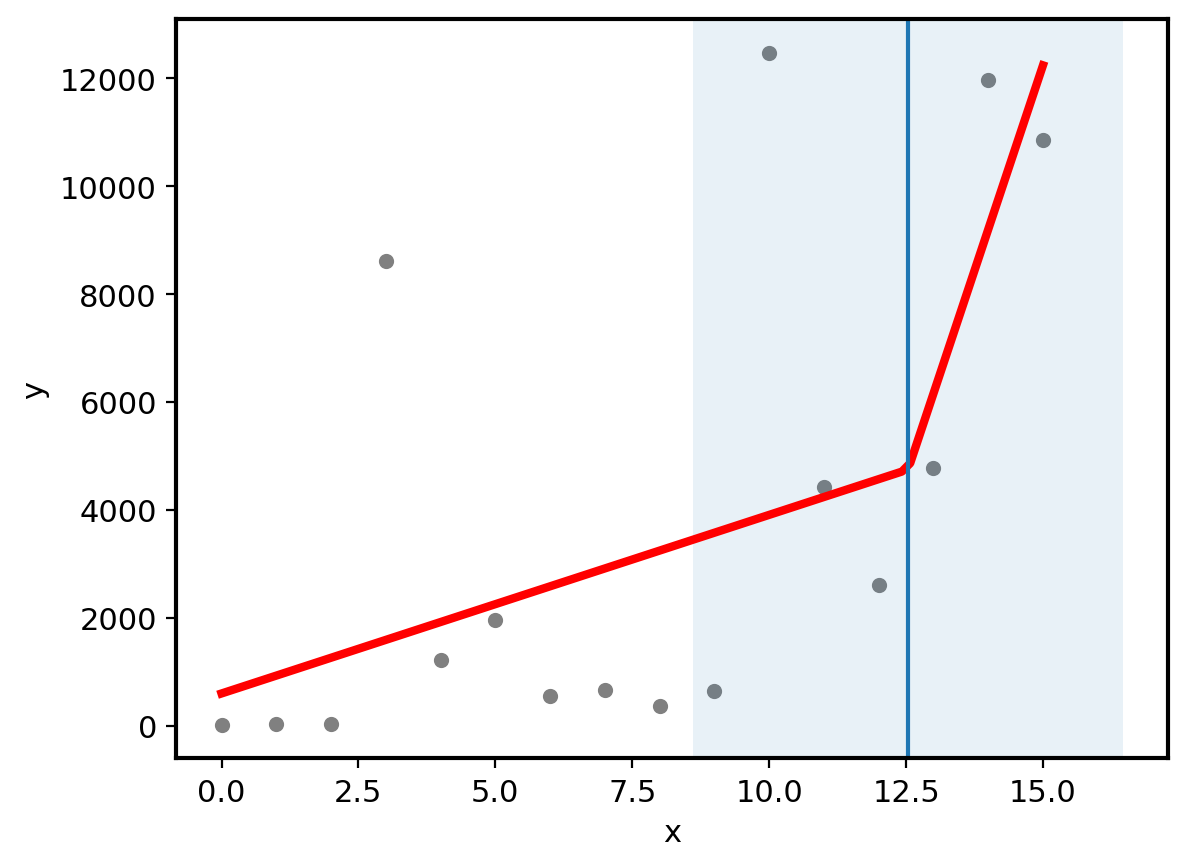

In [277]:
#%pip install piecewise-regression
import piecewise_regression
pw_fit = piecewise_regression.Fit(np.array(f.index), np.array(f['num_likes']), n_breakpoints=1)
pw_fit.summary()
# Plot the data, fit, breakpoints and confidence intervals
pw_fit.plot_data(color="grey", s=20)
# Pass in standard matplotlib keywords to control any of the plots
pw_fit.plot_fit(color="red", linewidth=3)
pw_fit.plot_breakpoints()
pw_fit.plot_breakpoint_confidence_intervals()
plt.xlabel("x")
plt.ylabel("y")
plt.show()
plt.close()

['alpha2']

                    Breakpoint Regression Results                     
No. Observations                       18
No. Model Parameters                    4
Degrees of Freedom                     14
Res. Sum of Squares           1.63484e+08
Total Sum of Squares          1.17417e+09
R Squared                        0.860766
Adjusted R Squared               0.817925
Converged:                           True
                    Estimate      Std Err            t        P>|t|       [0.025       0.975]
----------------------------------------------------------------------------------------------------
const                5062.53     1.63e+03        3.103       0.00779       1563.3       8561.7
alpha1               1615.08     1.85e+02       8.7148      4.99e-07       1217.6       2012.6
beta1               -7813.72     4.84e+03      -1.6157             -  -1.8186e+04       2559.0
breakpoint1          15.6213        0.663            -             -       14.199       17.044
------

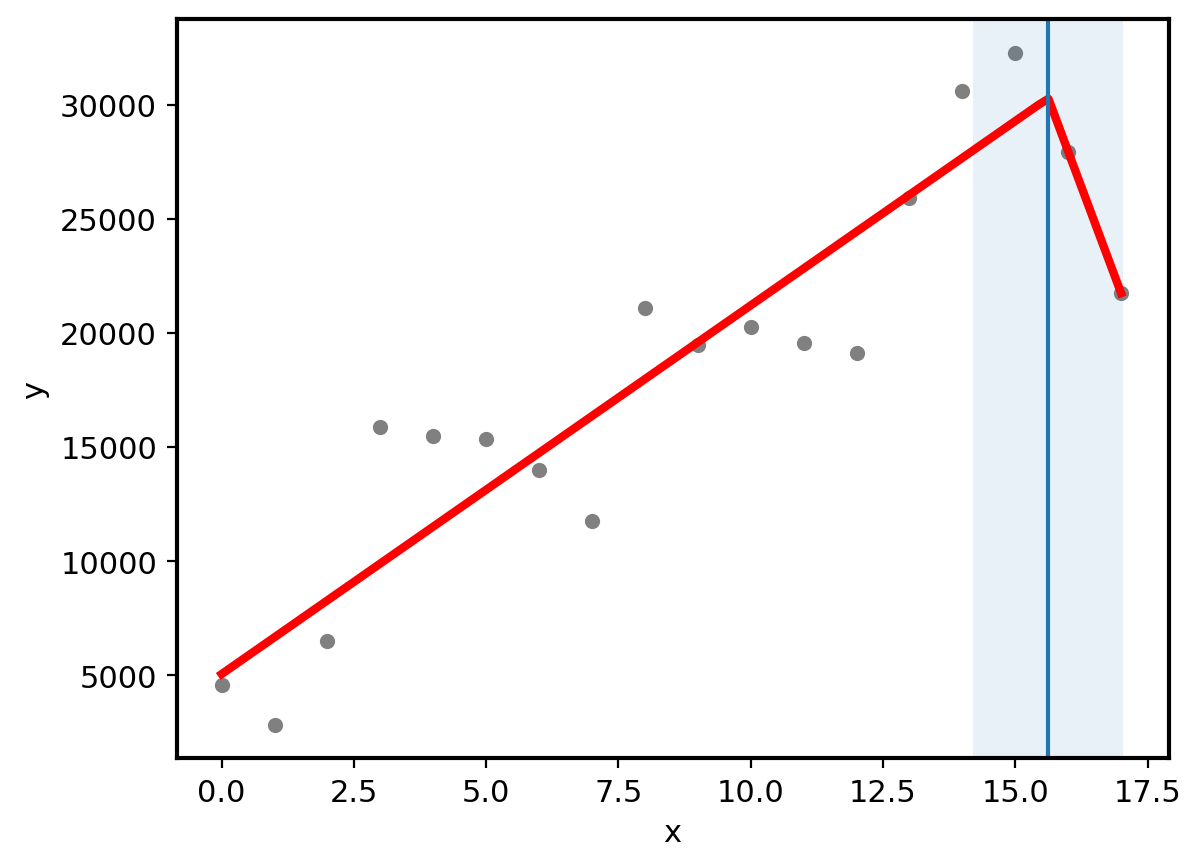

In [278]:
#%pip install piecewise-regression
pw_fit = piecewise_regression.Fit(np.array(f2.index), np.array(f2['num_likes']), n_breakpoints=1)
pw_fit.summary()
# Plot the data, fit, breakpoints and confidence intervals
pw_fit.plot_data(color="grey", s=20)
# Pass in standard matplotlib keywords to control any of the plots
pw_fit.plot_fit(color="red", linewidth=3)
pw_fit.plot_breakpoints()
pw_fit.plot_breakpoint_confidence_intervals()
plt.xlabel("x")
plt.ylabel("y")
plt.show()
plt.close()

In [279]:
plt.rcParams['axes.linewidth'] = 1.5
plt.rc('axes',edgecolor='black')

In [280]:
filtered_df = posts_df[(posts_df['num_likes'] >= 0) & (posts_df['is_reel'] == 0) & (posts_df['post_date'] <= "2011-06-01")]
merged_dfe= pd.merge(filtered_df, profiles_df, left_on='owner_username', right_on='username')
# ai_mdf = merged_df[merged_df["is_human_x"] == 0]
# h_mdf = merged_df[merged_df["is_human_x"] == 1]
merged_dfe["ER"] = (merged_dfe["num_likes"] + merged_dfe["num_comments"])# / merged_dfe['num_followers']
# Calculate average likes per group and date
print(merged_dfe.groupby(['is_human_x', pd.Grouper(key='post_date', freq=date_freq)]).groups)

{(1, 2010-12-31 00:00:00): [0], (1, 2011-03-31 00:00:00): [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27], (1, 2011-06-30 00:00:00): [28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101]}


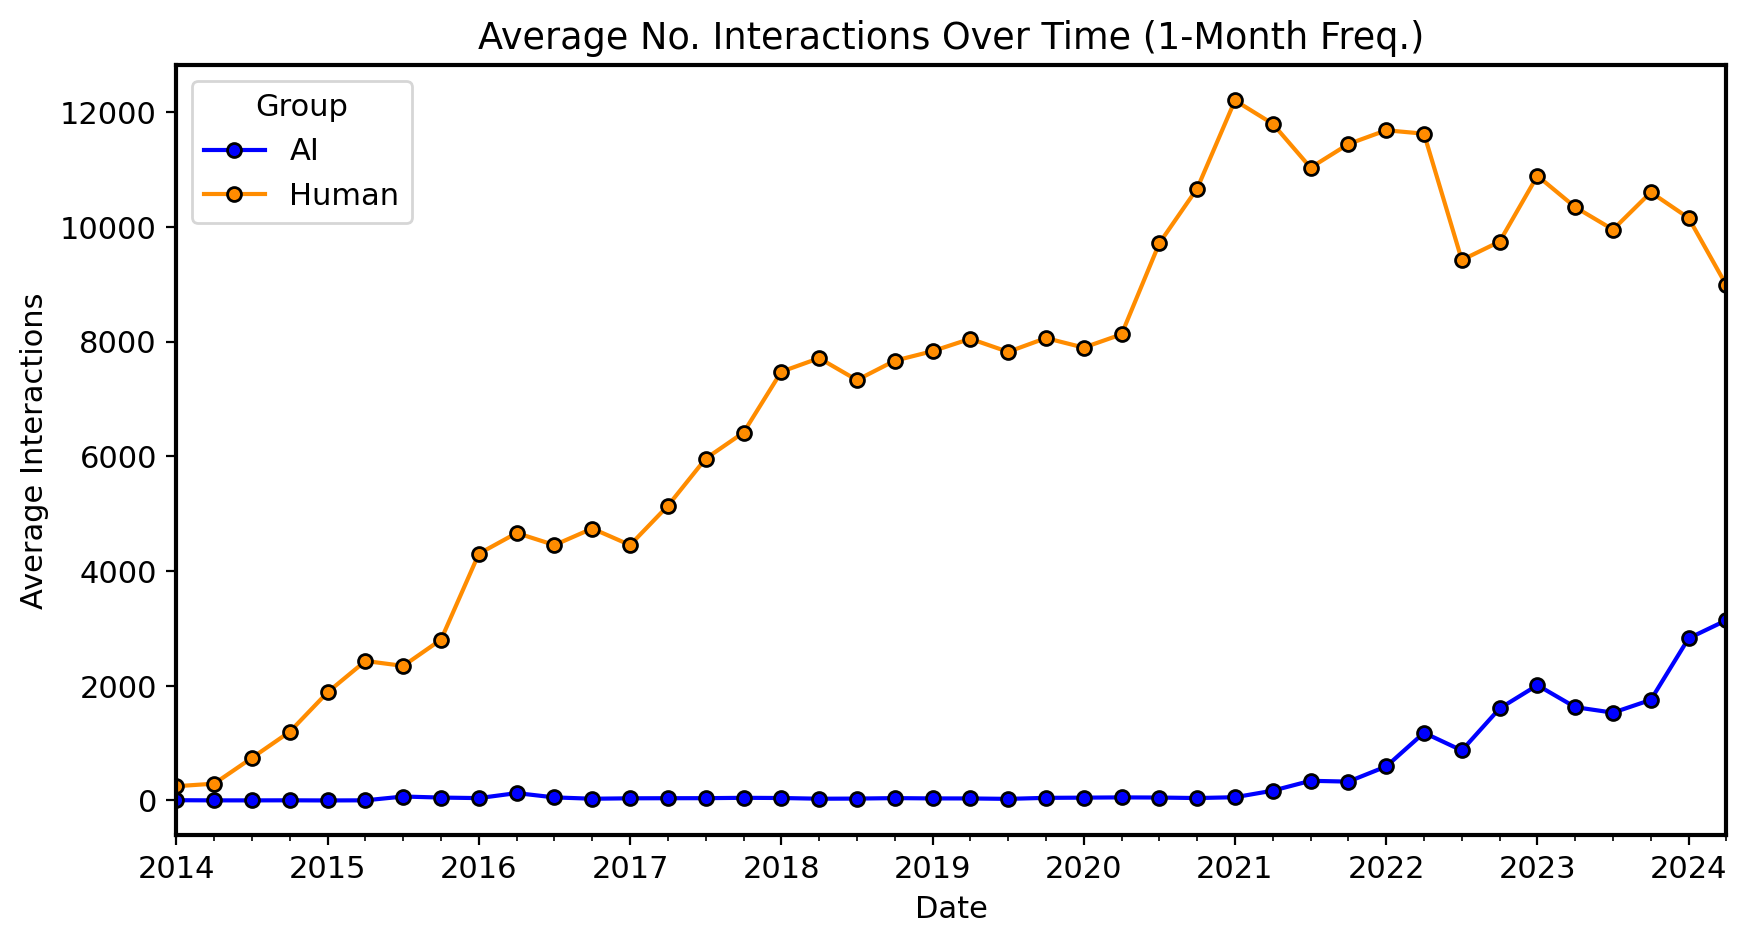

In [533]:
# import matplotlib.dates as mdates

filtered_df = posts_df[(posts_df['num_likes'] >= 0) & (posts_df['is_reel'] == 0) & (posts_df['post_date'] >= "2014-01-01")]
merged_dfe= pd.merge(filtered_df, profiles_df, left_on='owner_username', right_on='username')
# ai_mdf = merged_df[merged_df["is_human_x"] == 0]
# h_mdf = merged_df[merged_df["is_human_x"] == 1]
# merged_dfe = merged_dfe[(merged_dfe['num_followers'] >= 10000) & (merged_dfe['num_followers'] <= 100000)]
merged_dfe["ER"] = (merged_dfe["num_likes"] + merged_dfe["num_comments"])# / merged_dfe['num_followers']
# Calculate average likes per group and date
# print(merged_dfe.groupby(['is_human_x', pd.Grouper(key='post_date', freq=date_freq)]).groups)
avg_likes = merged_dfe.groupby(['is_human_x', pd.Grouper(key='post_date', freq=date_freq)])['ER'].mean().reset_index()

# avg_likes = filtered_df.groupby(["owner_username", pd.Grouper(key='owner_username')])['num_likes'].mean().reset_index()

# Pivot the data for easier plotting
pivot_df = avg_likes.pivot(index='post_date', columns='is_human_x', values='ER')

# Plotting
pivot_df.plot(kind='line', marker="o", markeredgecolor= "black", markersize= 5, figsize=(10, 5), color= ['blue', 'darkorange'])
plt.title('Average No. Interactions Over Time (1-Month Freq.)')
plt.xlabel('Date')
plt.ylabel('Average Interactions')
plt.grid(False)
plt.legend(title='Group', labels= ["AI", "Human"])
# plt.axis.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))

# # Rotates and right-aligns the x labels so they don't crowd each other.
# for label in plt.get_xticklabels(which='major'):
#     label.set(rotation=30, horizontalalignment='right')
# plt.tight_layout()
plt.show()

0


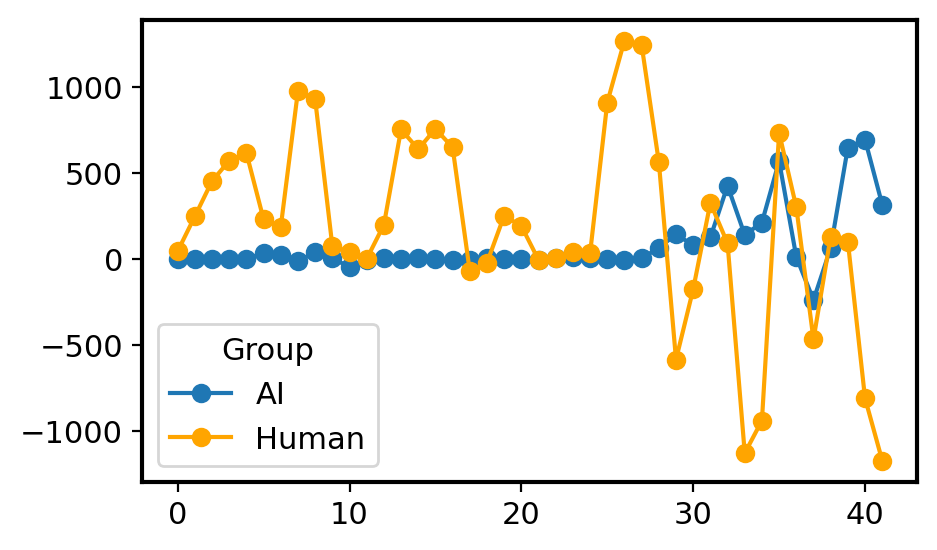

In [631]:
f = avg_likes[avg_likes["is_human_x"] == 0].reset_index()
dfdx = np.gradient(f["ER"], f.index)

f2 = avg_likes[avg_likes["is_human_x"] == 1].reset_index()
df2dx = np.gradient(f2["ER"], f2.index)
# print(len(f2) - len(f))

dfdx = np.pad(dfdx, (len(f2) - len(f),0))
# dfdx2
print(len(dfdx) - len(df2dx))
pd.Series(dfdx).plot(kind='line', marker='o', figsize=(5, 3))
pd.Series(df2dx).plot(kind='line', marker='o', figsize=(5, 3), color='orange')
plt.grid(False)
plt.legend(title='Group', labels= ["AI", "Human"])

In [283]:
pd.Series(df2dx).corr(pd.Series(dfdx))

-0.2929945605710652

In [39]:
#%pip install piecewise-regression
import piecewise_regression
pw_fit = piecewise_regression.Fit(np.array(f2.index), np.array(f2['ER']), n_breakpoints=1)
pw_fit.summary()
pass

['alpha2']

                    Breakpoint Regression Results                     
No. Observations                       42
No. Model Parameters                    4
Degrees of Freedom                     38
Res. Sum of Squares           1.85049e+07
Total Sum of Squares          5.16993e+08
R Squared                        0.964207
Adjusted R Squared               0.960337
Converged:                           True
                    Estimate      Std Err            t        P>|t|       [0.025       0.975]
----------------------------------------------------------------------------------------------------
const                453.172     2.49e+02       1.8231        0.0762      -50.035       956.38
alpha1               369.811         14.7       25.123      2.83e-25       340.01       399.61
beta1               -531.317         60.2      -8.8283             -      -653.15      -409.48
breakpoint1          29.6837        0.887            -             -       27.889       31.479
------

In [40]:
bp = pw_fit.get_results()["estimates"]["breakpoint1"]
# bp
print("breakpoint estimate: " + f2.iloc[int(np.ceil(bp["estimate"])),2].strftime("%Y-%m"))
print("95% CI: [" + f2.iloc[int(np.ceil(bp["confidence_interval"][0])),2].strftime("%Y-%m") + ", " + f2.iloc[int(np.ceil(bp["confidence_interval"][1])),2].strftime("%Y-%m") + "]")

breakpoint estimate: 2021-07
95% CI: [2021-01, 2022-01]


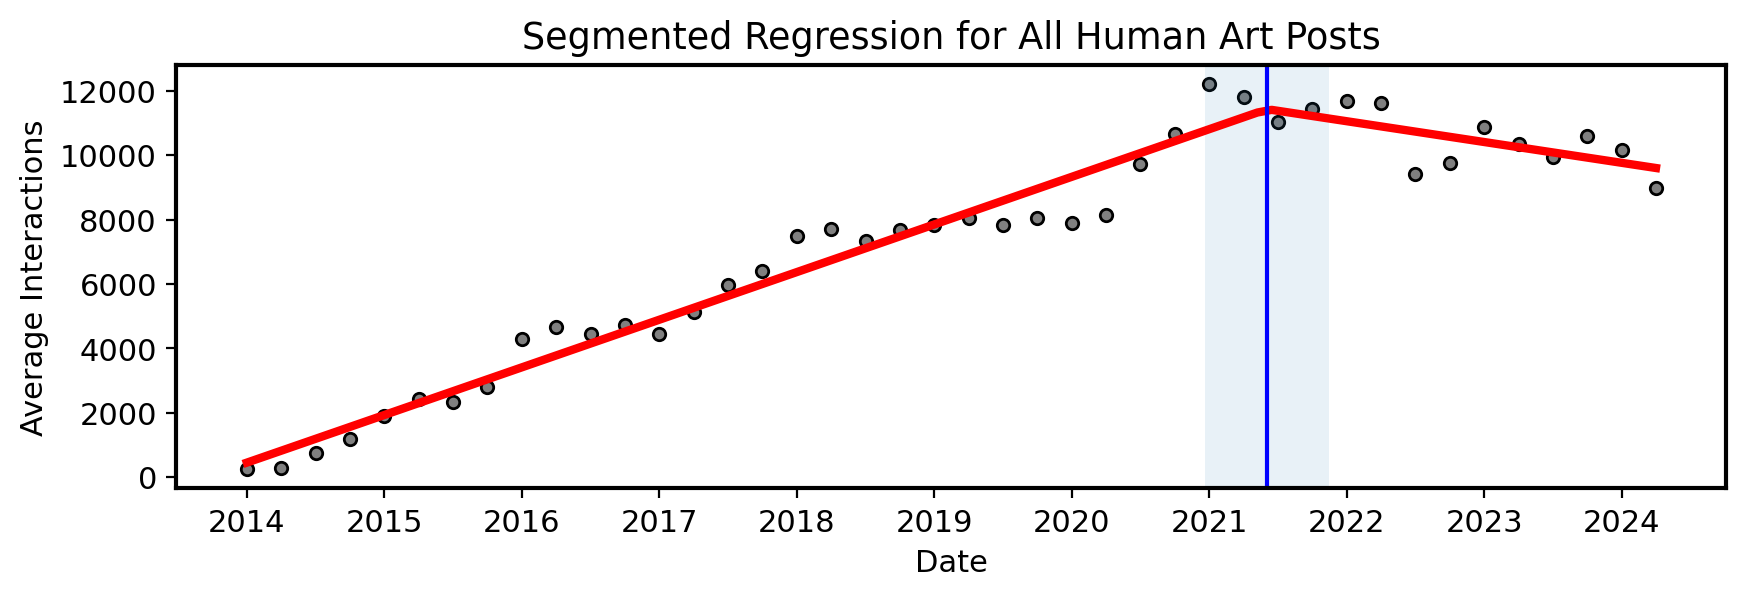

In [41]:
# Plot the data, fit, breakpoints and confidence intervals
fig, ax = plt.subplots(figsize=(10, 2.75))
pw_fit.plot_data(color="grey", s=20,  edgecolor= "black")
# Pass in standard matplotlib keywords to control any of the plots
pw_fit.plot_fit(color="red", linewidth=3)
pw_fit.plot_breakpoints(color= 'blue')
pw_fit.plot_breakpoint_confidence_intervals()
plt.title("Segmented Regression for All Human Art Posts")
plt.ylabel("Average Interactions")
plt.xlabel("Date")

ax.set_xticks(f2.index, minor=False, labels=pd.date_range(f2.iloc[0,2], f2.iloc[-1,2], freq=date_freq).year)
plt.locator_params(nbins=11)
plt.show()

In [42]:
pw_fit = piecewise_regression.Fit(np.array(f.index), np.array(f['ER']), n_breakpoints=1)
pw_fit.summary()
pass

['alpha2']

                    Breakpoint Regression Results                     
No. Observations                       42
No. Model Parameters                    4
Degrees of Freedom                     38
Res. Sum of Squares           1.29079e+06
Total Sum of Squares          2.67093e+07
R Squared                        0.951672
Adjusted R Squared               0.946448
Converged:                           True
                    Estimate      Std Err            t        P>|t|       [0.025       0.975]
----------------------------------------------------------------------------------------------------
const                15.2142         65.7      0.23175         0.818      -117.69       148.12
alpha1               1.88893         3.89      0.48588          0.63      -5.9812       9.7591
beta1                228.319         15.9       14.364             -       196.14        260.5
breakpoint1          29.3564        0.559            -             -       28.226       30.487
------

In [43]:
bp = pw_fit.get_results()["estimates"]["breakpoint1"]
# bp
print("breakpoint estimate: " + f.iloc[int(np.ceil(bp["estimate"])),2].strftime("%Y-%m"))
print("95% CI: [" + f.iloc[int(np.ceil(bp["confidence_interval"][0])),2].strftime("%Y-%m") + ", " + f.iloc[int(np.ceil(bp["confidence_interval"][1])),2].strftime("%Y-%m") + "]")

breakpoint estimate: 2021-07
95% CI: [2021-04, 2021-10]


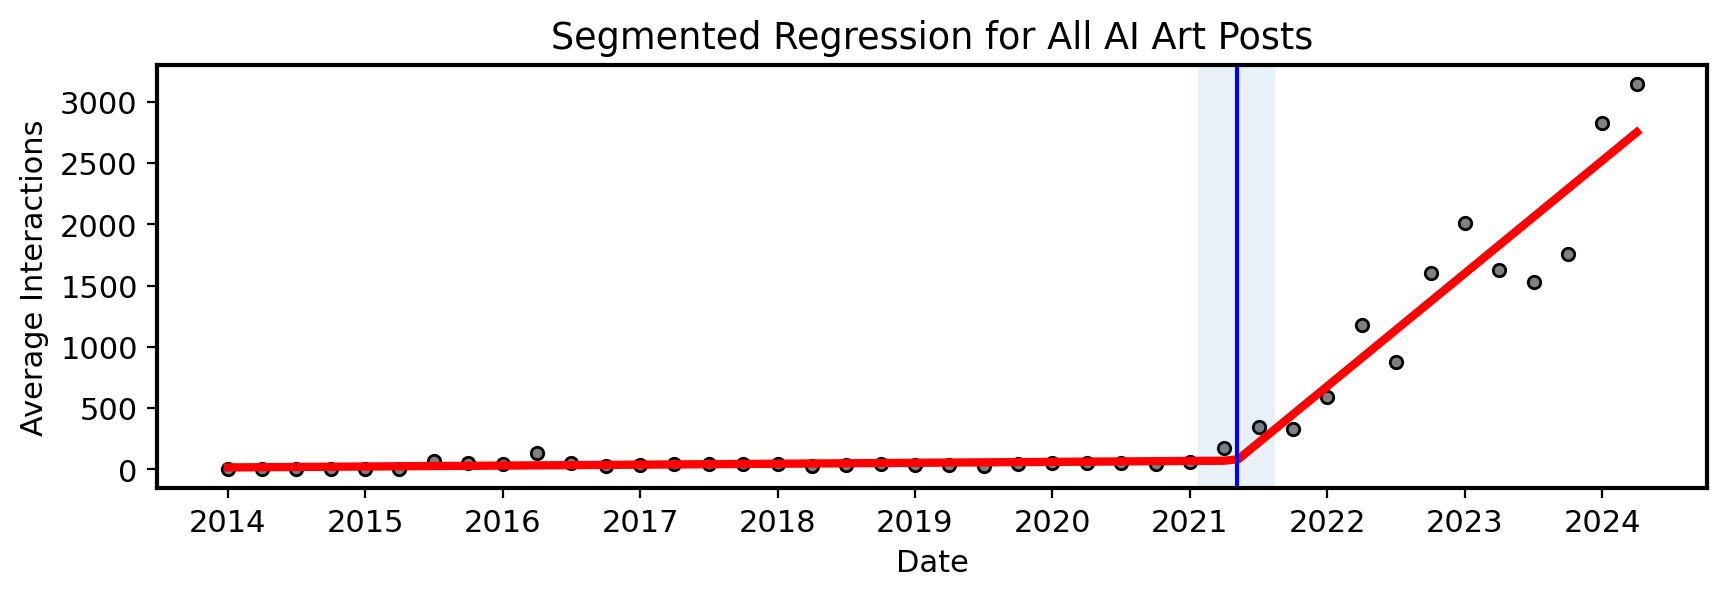

In [44]:
# Plot the data, fit, breakpoints and confidence intervals
fig, ax = plt.subplots(figsize=(10, 2.75))
pw_fit.plot_data(color="grey", s=20, edgecolor= "black")
# Pass in standard matplotlib keywords to control any of the plots
pw_fit.plot_fit(color="red", linewidth=3)
pw_fit.plot_breakpoints(color= 'blue')
pw_fit.plot_breakpoint_confidence_intervals()
plt.title("Segmented Regression for All AI Art Posts")
plt.ylabel("Average Interactions")
plt.xlabel("Date")

ax.set_xticks(f2.index, minor=False, labels=pd.date_range(f.iloc[0,2], f.iloc[-1,2], freq=date_freq).year)
plt.locator_params(nbins=11)
plt.show()

In [671]:
# import piecewise_regression.davies as davies
from piecewise_regression import davies_test
def summary(sr: pwlf.PiecewiseLinFit):
    print("Segmented Regression Results")
    print("------------------------------")
    print(f"No. Observations: {sr.n_data}")
    print(f"No. Breakpoints: {sr.n_parameters - 2}")
    print(f"Sum of Squares: {sr.ssr}")
    print(f"Total Sum of Squares: {sr.ssr/ sr.r_squared()}")
    print(f"R^2: {sr.r_squared()}")
    print("------------------------------")
    params = sr.beta
    se = sr.standard_errors()
    pv = sr.p_values()
    print(f"b1: Estimate={params[0]}    Std. Err={se[0]}    p-value={pv[0]}")
    print(f"b2: Estimate={params[1]}    Std. Err={se[1]}    p-value={pv[1]}")
    print(f"b3: Estimate={params[2]}    Std. Err={se[2]}    p-value={pv[2]}")
    print(f"a1: Estimate={sr.slopes[-1]}")
    print("-------------------------------")
    print(f"Davies test for existence of at least 1 breakpoint: p={davies_test(sr.x_data, sr.y_data)}")
    print(f"(e.g. p<0.05 means reject null hypothesis of no breakpoints at 5% significance)")

 message: Optimization terminated successfully.
 success: True
     fun: 1290794.4867633847
       x: [ 2.936e+01]
     nit: 7
    nfev: 416
     jac: [-2.328e-02]
Segmented Regression Results
------------------------------
No. Observations: 42
No. Breakpoints: 1
Sum of Squares: 1290794.4867633847
Total Sum of Squares: 1356343.2151980605
R^2: 0.9516724618811883
------------------------------
b1: Estimate=15.214227216335692    Std. Err=62.68413816563549    p-value=0.8095000487825429
b2: Estimate=1.8889271410524806    Std. Err=3.421392376671805    p-value=0.5840347669554853
b3: Estimate=228.31893115763313    Std. Err=12.443128103092743    p-value=8.767657380598148e-21
a1: Estimate=230.2078582986856
-------------------------------
Davies test for existence of at least 1 breakpoint: p=2.4095107205102994e-57
(e.g. p<0.05 means reject null hypothesis of no breakpoints at 5% significance)


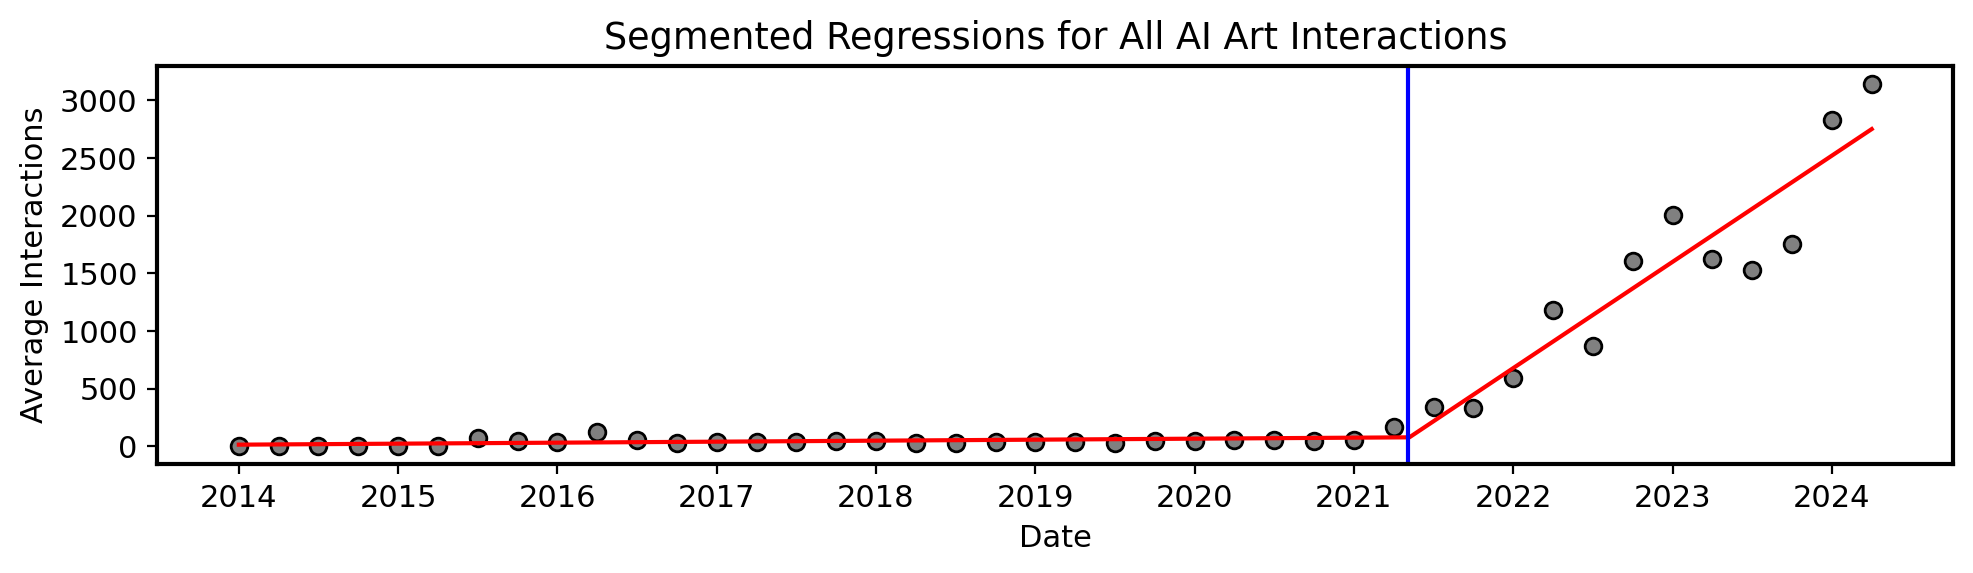

In [672]:
import pwlf
fig, ax = plt.subplots(figsize=(10, 3))
# initialize piecewise linear fit with your x and y data
x = np.array(f.index)
y = np.array(f['ER'])
aisr = pwlf.PiecewiseLinFit(np.array(f.index), np.array(f['ER']), disp_res= True)

# fit the data for four line segments
res = aisr.fit(2)
summary(aisr)
# asir.pr
# predict for the determined points
xHat = np.linspace(min(x), max(x), num=10000)
yHat = aisr.predict(xHat)

ax.plot(np.array(f.index), np.array(f['ER']), 'o', color= "grey", markeredgecolor= "black")
ax.plot(xHat, yHat, '-', color= 'red')
ax.set_xticks(f2.index, minor=False, labels=pd.date_range(f2.iloc[0,2], f2.iloc[-1,2], freq=date_freq).year)
ax.axvline(aisr.fit_breaks[1], color= "blue")
ax.set_title("Segmented Regressions for All AI Art Interactions")

ax.set_ylabel("Average Interactions")
ax.set_xlabel("Date")
plt.locator_params(nbins=11)
plt.tight_layout()
# print(aisr.p_values())
# print(aisr.calc_slopes())

# print("breakpoint estimate: " + f2.iloc[int(np.ceil(aisr.fit_breaks[1])),2].strftime("%Y-%m"))
# print("95% CI: [" + f2.iloc[int(np.ceil(bp["confidence_interval"][0])),2].strftime("%Y-%m") + ", " + f2.iloc[int(np.ceil(bp["confidence_interval"][1])),2].strftime("%Y-%m") + "]")

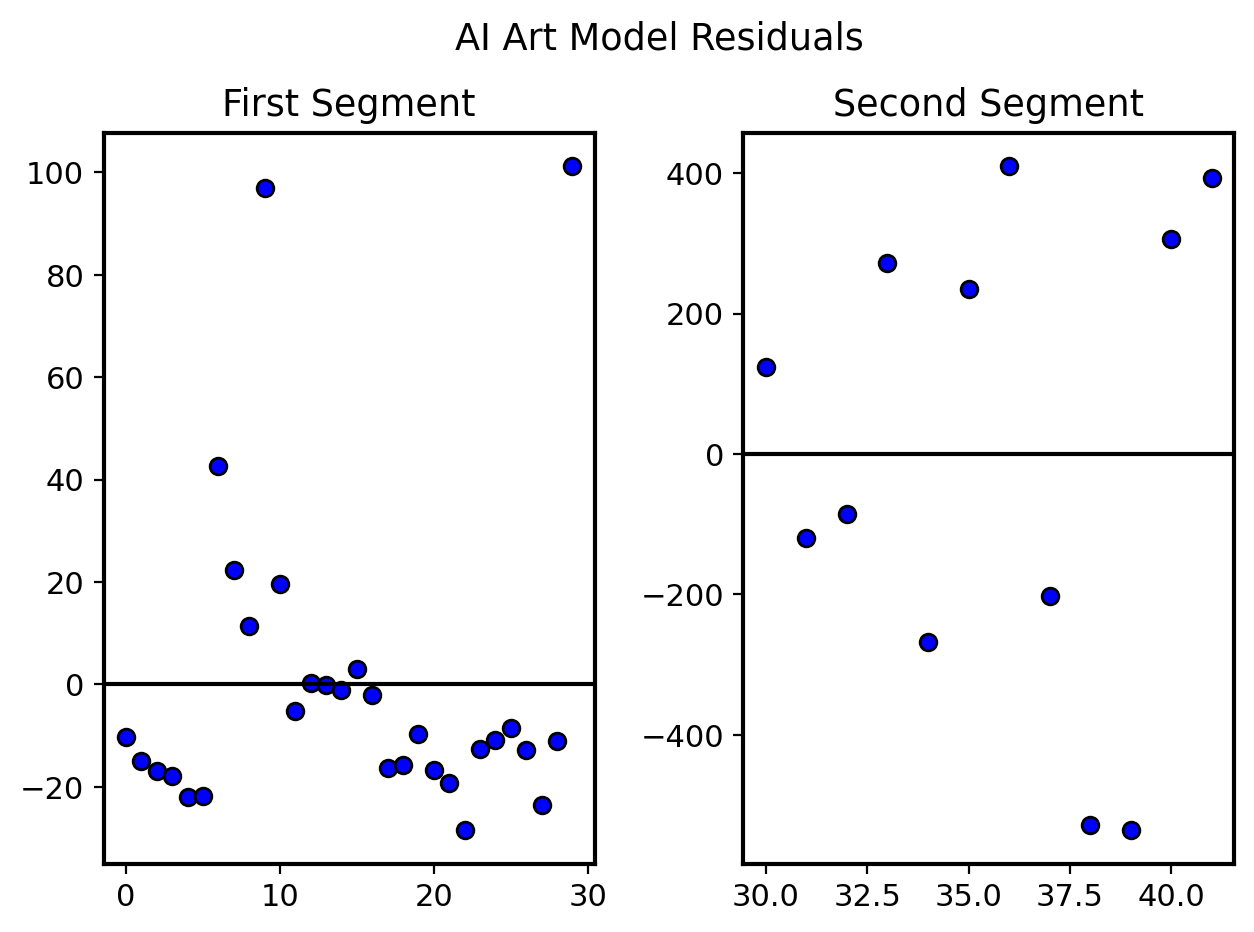

In [637]:
# yHat = hsr.predict(x)
# print(yHat)
xHat = np.linspace(min(x), max(x), num=len(x))
yHat = aisr.predict(xHat)
ax= plt.subplot(1, 2, 1)
ax.plot(x[:-12], (y - yHat)[:-12], "bo", markeredgecolor= "black")
ax.axhline(0, color= "black")
plt.title('First Segment')
# ax.set_xticks(f2.index[:-12:7], minor=False, labels=(pd.date_range(f2.iloc[0,2], f2.iloc[-1,2], freq=date_freq).year)[:-12:7])

ax = plt.subplot(1, 2, 2)
# ax.plot(x[-12:], (y - yHat)[-12:], marker= 'o', color= "grey", markeredgecolor= "black", kind="scatter")
ax.plot(x[-12:], (y - yHat)[-12:], "bo", markeredgecolor= "black")
ax.axhline(0, color= "black")
plt.title('Second Segment')

# plt.xticks()
# ax.set_xticks(f2.index[-12:4], minor=False, labels=(pd.date_range(f2.iloc[0,2], f2.iloc[-1,2], freq=date_freq).year)[-12:])
plt.suptitle('AI Art Model Residuals', x= 0.525, y= 0.965)

plt.tight_layout()
plt.show()

In [656]:
def srwbp(y, fs= (10, 3), title=""):
    fig, ax = plt.subplots(figsize=fs)
    # initialize piecewise linear fit with your x and y data
    x = np.arange(len(y))
    hsr = pwlf.PiecewiseLinFit(x, np.array(y), disp_res= True)
    # hsr.print = True
    res = hsr.fit_with_breaks(aisr.fit_breaks)
    summary(hsr)
    # predict for the determined points
    xHat = np.linspace(min(x), max(x), num=10000)
    yHat = hsr.predict(xHat)

    ax.plot(x, np.array(y), 'o', color= "grey", markeredgecolor= "black")
    ax.plot(xHat, yHat, '-', color= 'red')
    ax.set_xticks(f2.index, minor=False, labels=pd.date_range(f2.iloc[0,2], f2.iloc[-1,2], freq=date_freq).year)
    ax.axvline(hsr.fit_breaks[1], color= "blue")
    ax.set_title(title)

    ax.set_ylabel("Average Interactions")
    ax.set_xlabel("Date")
    plt.locator_params(nbins=11)
    plt.tight_layout()
    plt.show()

Segmented Regression Results
------------------------------
No. Observations: 42
No. Breakpoints: 1
Sum of Squares: 18568109.125898983
Total Sum of Squares: 19259837.133551214
R^2: 0.9640844310958778
------------------------------
b1: Estimate=430.46423279512294    Std. Err=237.74615515231372    p-value=0.0779111403547248
b2: Estimate=372.2116524205523    Std. Err=12.976567644384422    p-value=7.9276953754581095e-28
b3: Estimate=-518.111934918517    Std. Err=47.19341944761313    p-value=1.7046172595457347e-13
a1: Estimate=-145.90028249796467
-------------------------------


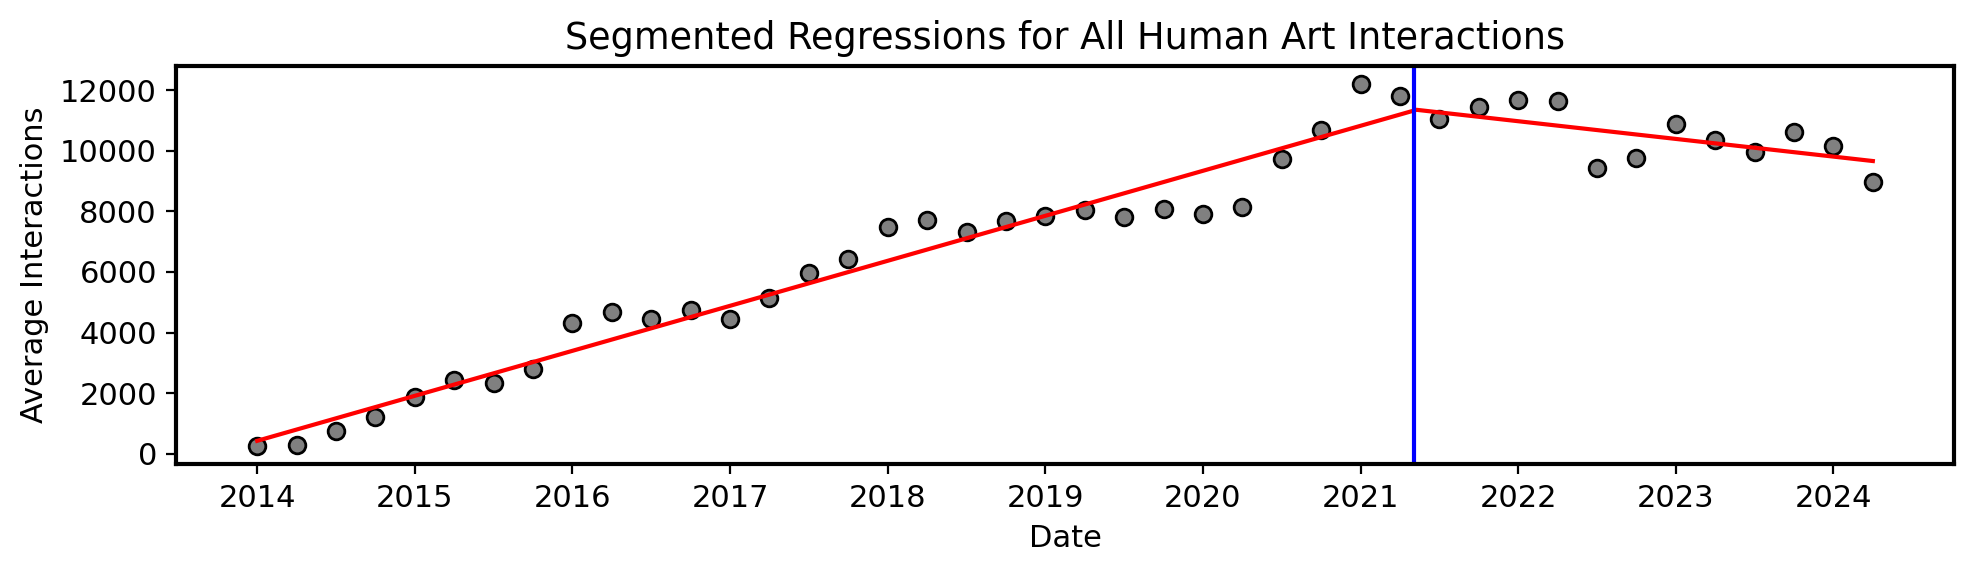

In [660]:
fig, ax = plt.subplots(figsize=(10, 3))
# initialize piecewise linear fit with your x and y data
x = np.array(f2.index)
y = np.array(f2['ER'])
hsr = pwlf.PiecewiseLinFit(np.array(f2.index), np.array(f2['ER']), disp_res= True)
# hsr.print = True
res = hsr.fit_with_breaks(aisr.fit_breaks)
summary(hsr)
# predict for the determined points
xHat = np.linspace(min(x), max(x), num=10000)
yHat = hsr.predict(xHat)
dfg = yHat
ax.plot(np.array(f2.index), np.array(f2['ER']), 'o', color= "grey", markeredgecolor= "black")
ax.plot(xHat, yHat, '-', color= 'red')
ax.set_xticks(f2.index, minor=False, labels=pd.date_range(f2.iloc[0,2], f2.iloc[-1,2], freq=date_freq).year)
ax.axvline(hsr.fit_breaks[1], color= "blue")
ax.set_title("Segmented Regressions for All Human Art Interactions")

ax.set_ylabel("Average Interactions")
ax.set_xlabel("Date")
plt.locator_params(nbins=11)
plt.tight_layout()

# print("breakpoint estimate: " + f2.iloc[int(np.ceil(hsr.fit_breaks[1])),2].strftime("%Y-%m"))
# print("95% CI: [" + f2.iloc[int(np.ceil(bp["confidence_interval"][0])),2].strftime("%Y-%m") + ", " + f2.iloc[int(np.ceil(bp["confidence_interval"][1])),2].strftime("%Y-%m") + "]")

In [653]:
hsr

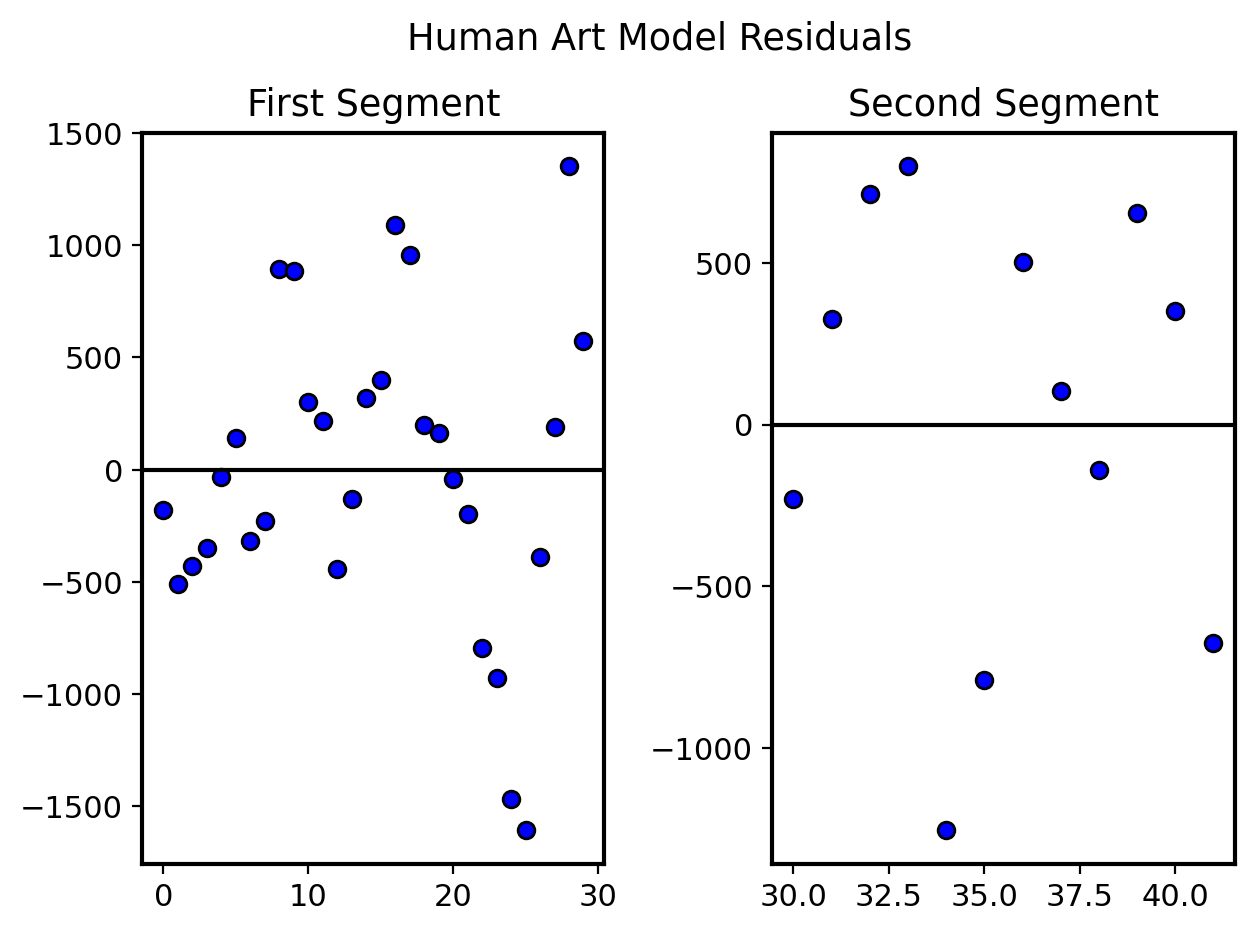

In [661]:
# yHat = hsr.predict(x)
xHat = np.linspace(min(x), max(x), num=len(x))

yHat = hsr.predict(xHat)
ax= plt.subplot(1, 2, 1)
ax.plot(x[:-12], (y - yHat)[:-12], "bo", markeredgecolor= "black")
ax.axhline(0, color= "black")
plt.title('First Segment')

ax = plt.subplot(1, 2, 2)
ax.plot(x[-12:], (y - yHat)[-12:], "bo", markeredgecolor= "black")
ax.axhline(0, color= "black")
plt.title('Second Segment')

# plt.xticks()
# ax.set_xticks(f2.index[-12:4], minor=False, labels=(pd.date_range(f2.iloc[0,2], f2.iloc[-1,2], freq=date_freq).year)[-12:])
plt.suptitle('Human Art Model Residuals', x= 0.525, y= 0.965)

plt.tight_layout()
plt.show()

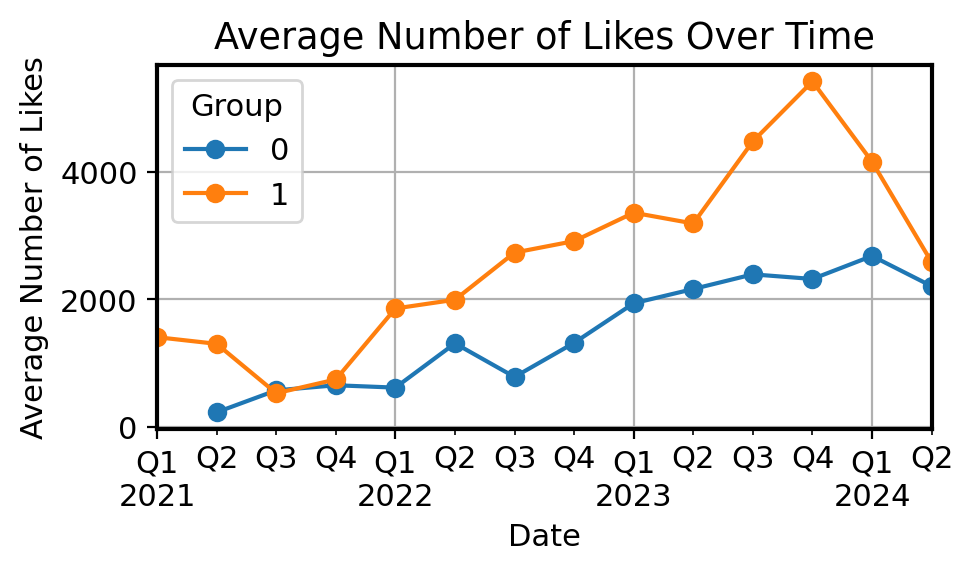

In [45]:
new = pd.DataFrame()
for p in merged_dfe["owner_username"].unique():
   if (merged_dfe[merged_dfe["owner_username"] == p]["post_date"].min()) > pd.to_datetime("2021-1-1")  and (merged_dfe[merged_dfe["owner_username"] == p]["post_date"].min()) < pd.to_datetime("2023-1-1"):
      new = pd.concat([new, merged_dfe[merged_dfe["owner_username"] == p]], ignore_index=True)


# these r the proiles that started after 20203-6-1, plot these out
avg_likes = new.groupby(['is_human_x', pd.Grouper(key='post_date', freq=date_freq)])['ER'].mean().reset_index()

# avg_likes = filtered_df.groupby(["owner_username", pd.Grouper(key='owner_username')])['num_likes'].mean().reset_index()
# print(new[new["ER"] > 1][["owner_username", "num_likes", "num_comments", "num_followers", "ER", "is_reel"]])
# print(new[new["is_human_x"] == 1].describe())
# print("------------------------------------------")
# print(new[new["is_human_x"] == 0].describe())
# Pivot the data for easier plotting
pivot_df = avg_likes.pivot(index='post_date', columns='is_human_x', values='ER')

# Plotting
pivot_df.plot(kind='line', marker='o', figsize=(5, 3))
plt.title('Average Number of Likes Over Time')
plt.xlabel('Date')
plt.ylabel('Average Number of Likes')
plt.grid(True)
plt.legend(title='Group')
plt.tight_layout()
plt.show()

In [438]:
# merged_df= pd.merge(filtered_df, profiles_df, left_on='owner_username', right_on='username')
merged_df = merged_dfe
ai_mdf = merged_df[merged_df["is_human_x"] == 0]
h_mdf = merged_df[merged_df["is_human_x"] == 1]

In [439]:
avgh = h_mdf.groupby([pd.Grouper(key='post_date', freq=date_freq), pd.cut(merged_df['num_followers'], [0, 10000, 50000, 100000, 500000, 100000000])], observed=True, dropna=False)
cts = {}
for col in pd.cut(merged_df['num_followers'], [0, 10000, 50000, 100000, 500000, 100000000]).unique():
    cts[col] = 0

s = []

for group_key, indices in avgh.groups.items():
    group_size = len(indices)
    cts[group_key[1]] += group_size

total = 0
cts

print("Dataset Breakdown:")
for c in cts:
    print(f"{c}: {cts[c]}   {cts[c]/h_mdf.shape[0]}")

Dataset Breakdown:
(0, 10000]: 4511   0.042597996166085915
(10000, 50000]: 14876   0.14047612302520374
(50000, 100000]: 14163   0.13374316552876853
(100000, 500000]: 34031   0.32135943416716245
(500000, 100000000]: 38316   0.3618232811127794


In [440]:
avgh = h_mdf.groupby([pd.Grouper(key='post_date', freq=date_freq), pd.cut(merged_df['num_followers'], [0, 10000, 50000, 100000, 500000, 10000000])], observed=True)['ER'].mean().reset_index()
avgai = ai_mdf.groupby([pd.Grouper(key='post_date', freq=date_freq), pd.cut(merged_df['num_followers'], [0, 10000, 50000, 100000, 500000])], observed=True)['ER'].mean().reset_index()

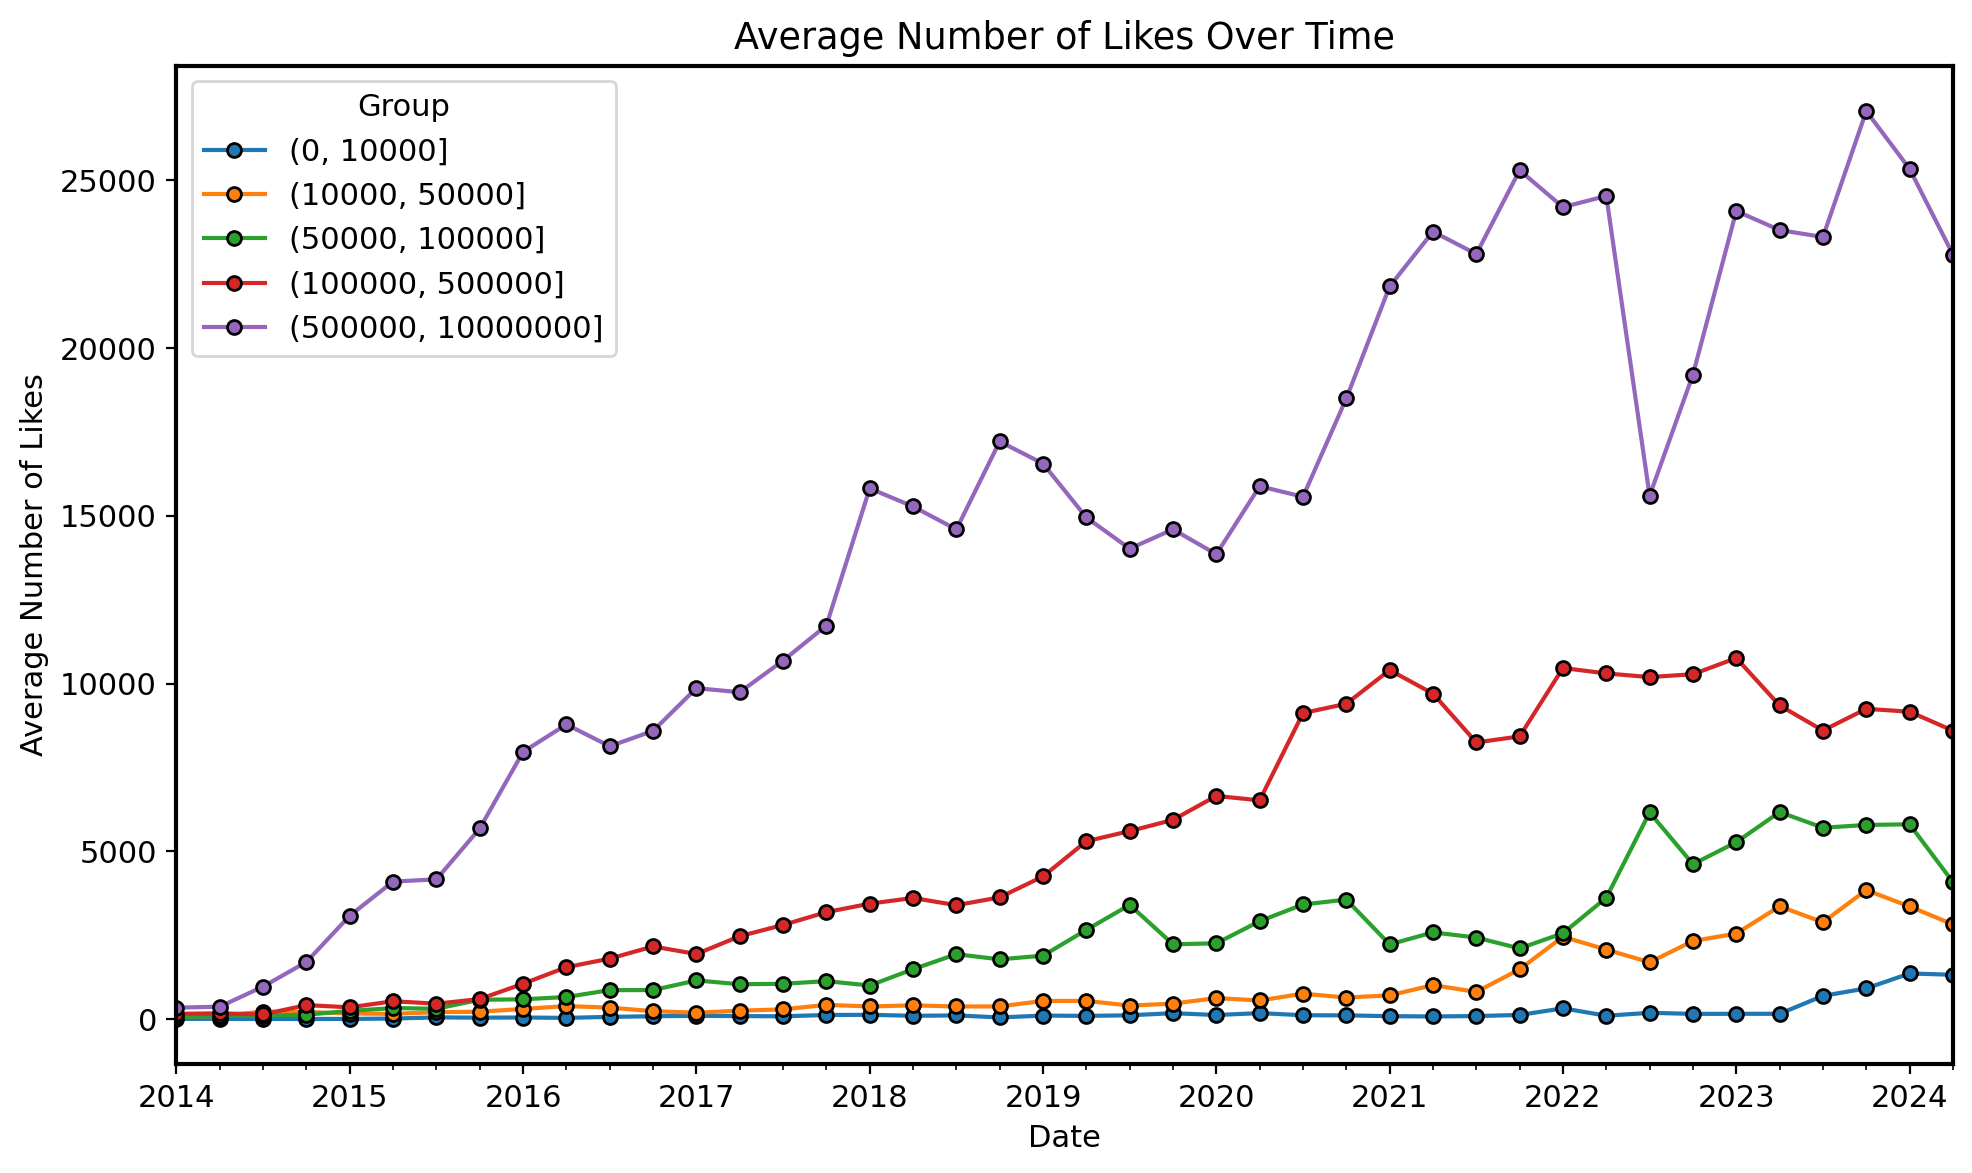

In [441]:
# smpl_avg_likes =  test.groupby([pd.Grouper(key='post_date', freq=date_freq), 'is_human_x']).mean().reset_index()

pivot_df = avgh.pivot(index='post_date', columns='num_followers', values='ER')

# Plotting
pivot_df.plot(kind='line', marker="o", markeredgecolor= "black", markersize= 5, figsize=(10, 6))
plt.title('Average Number of Likes Over Time')
plt.xlabel('Date')
plt.ylabel('Average Number of Likes')
# plt.grid(True)
plt.legend(title='Group')
plt.tight_layout()
plt.show()

Segmented Regression Results
------------------------------
No. Observations: 42
No. Breakpoints: 1
Sum of Squares: 1098109.2824999457
Total Sum of Squares: 1525884.300836508
R^2: 0.719654355115882
------------------------------
b1: Estimate=60.78940936104431    Std. Err=57.81651226401089    p-value=0.2995373854380766
b2: Estimate=-0.5150343208476977    Std. Err=3.155710201640981    p-value=0.8711981708468386
b3: Estimate=79.10119262152595    Std. Err=11.476878997292449    p-value=3.0139863192209315e-08
a1: Estimate=78.58615830067825
-------------------------------


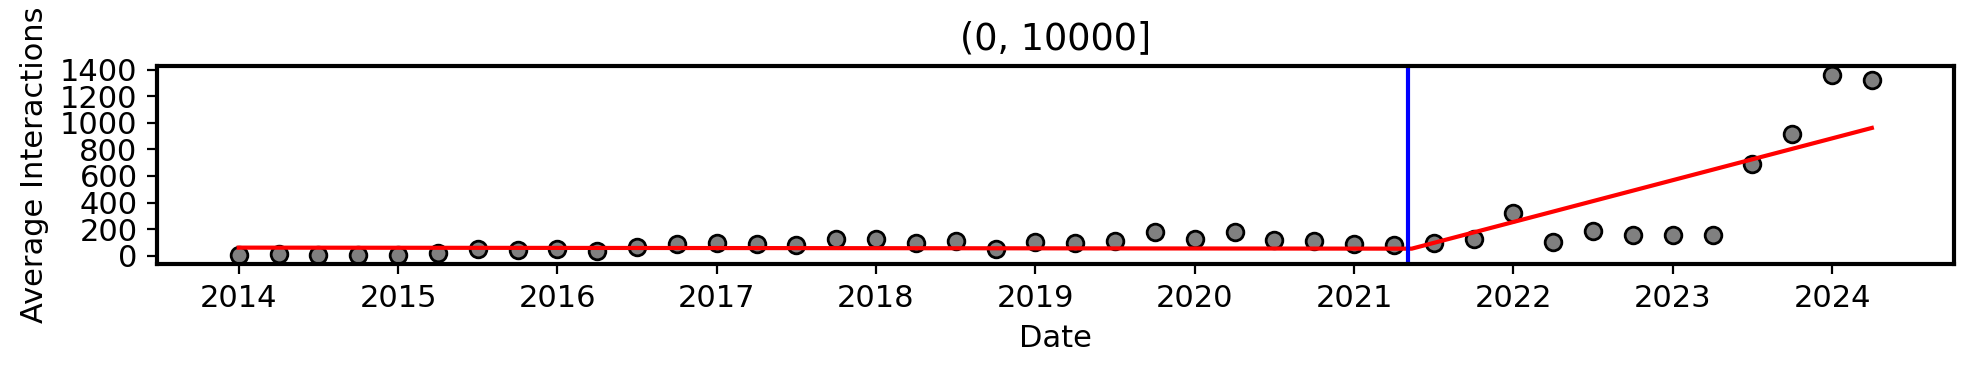

Segmented Regression Results
------------------------------
No. Observations: 42
No. Breakpoints: 1
Sum of Squares: 3207743.45250214
Total Sum of Squares: 3443143.344170423
R^2: 0.9316322708240311
------------------------------
b1: Estimate=0.8754603442688288    Std. Err=98.81637586068084    p-value=0.9929764260868805
b2: Estimate=29.046269182053337    Std. Err=5.393543006689612    p-value=3.689296177040208e-06
b3: Estimate=219.87465820368058    Std. Err=19.615565593532892    p-value=9.164438196980953e-14
a1: Estimate=248.9209273857339
-------------------------------


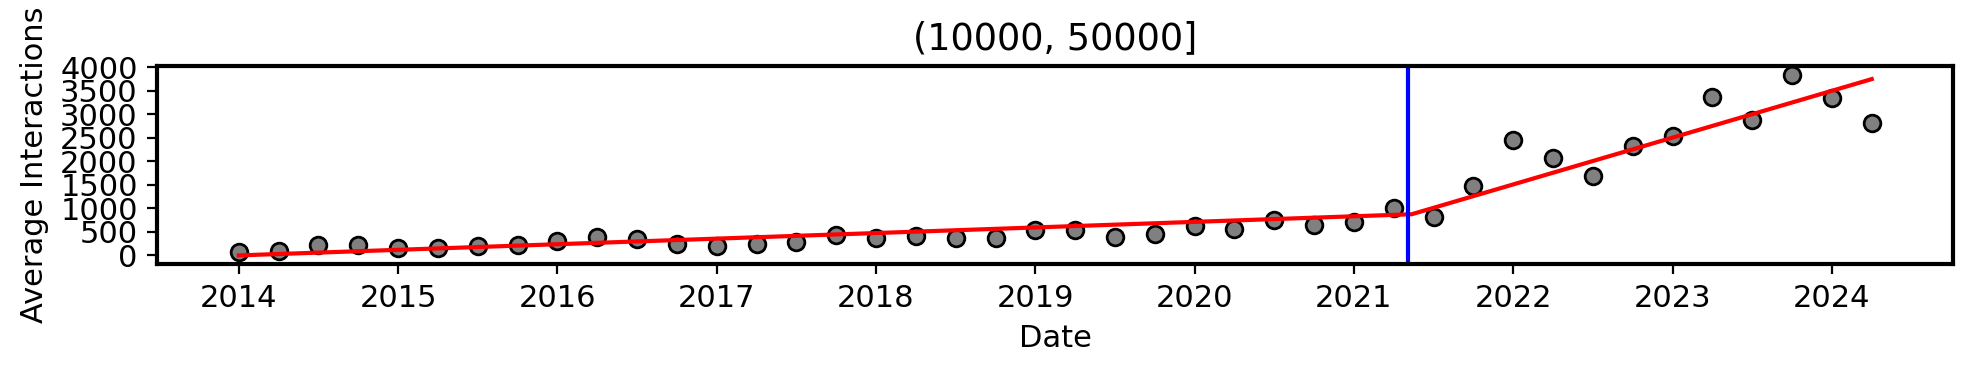

Segmented Regression Results
------------------------------
No. Observations: 42
No. Breakpoints: 1
Sum of Squares: 17778142.806117848
Total Sum of Squares: 20307267.844068725
R^2: 0.875457148772006
------------------------------
b1: Estimate=-196.07915563088721    Std. Err=232.63352611358755    p-value=0.4044424851067806
b2: Estimate=109.31076674668546    Std. Err=12.69747971389365    p-value=1.487068224963869e-10
b3: Estimate=149.4874372628676    Std. Err=46.1789673117494    p-value=0.0024660161097151303
a1: Estimate=258.7982040095531
-------------------------------


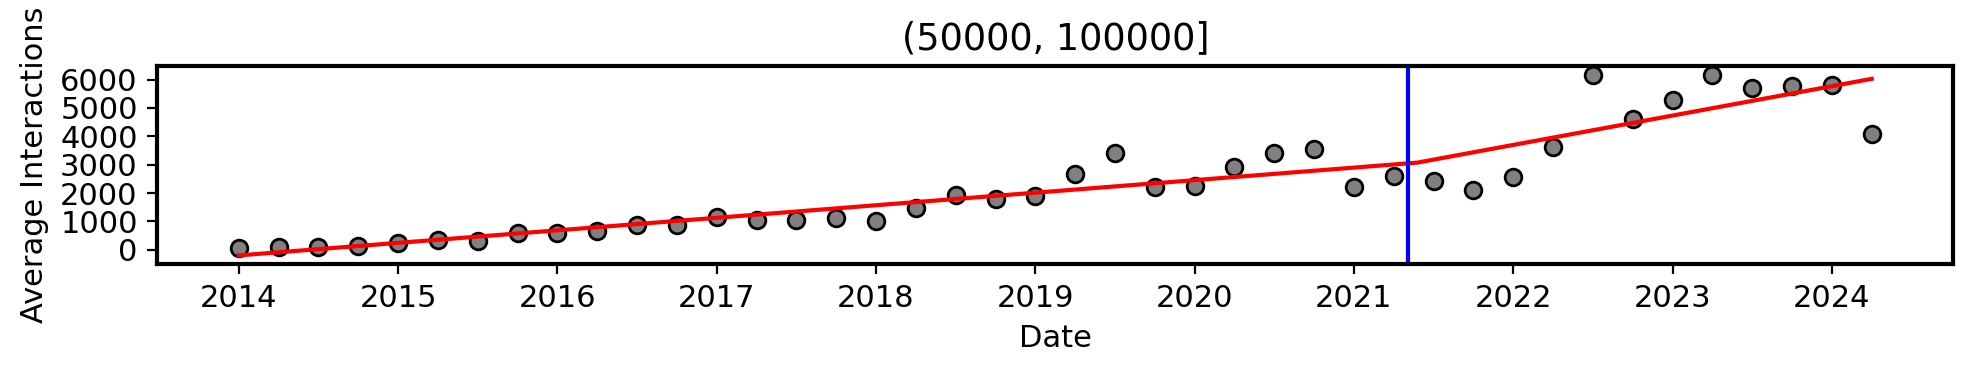

Segmented Regression Results
------------------------------
No. Observations: 42
No. Breakpoints: 1
Sum of Squares: 37570960.81758293
Total Sum of Squares: 40117334.208564125
R^2: 0.9365268545077553
------------------------------
b1: Estimate=-1484.9998070013962    Std. Err=338.1857150628517    p-value=8.363054455107646e-05
b2: Estimate=353.0286611785486    Std. Err=18.458673297341083    p-value=2.0394218621240932e-21
b3: Estimate=-287.06388332837304    Std. Err=67.13162690730445    p-value=0.00011890420843461103
a1: Estimate=65.96477785017558
-------------------------------


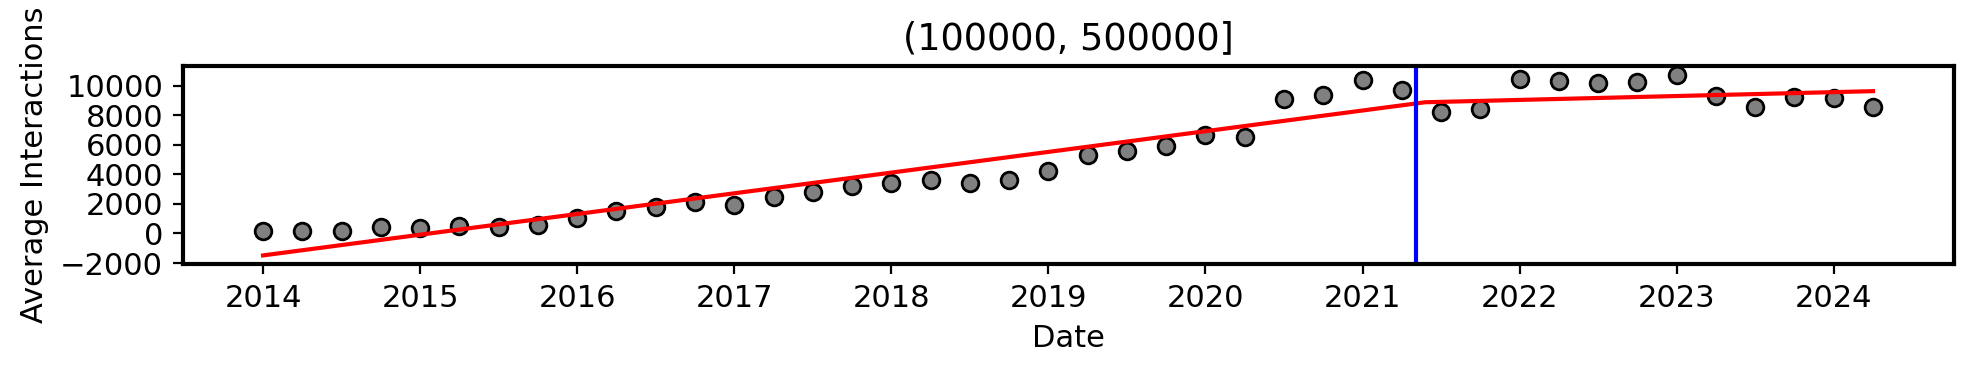

Segmented Regression Results
------------------------------
No. Observations: 42
No. Breakpoints: 1
Sum of Squares: 198462575.55839458
Total Sum of Squares: 215182852.7152211
R^2: 0.9222973534096854
------------------------------
b1: Estimate=769.3162213768713    Std. Err=777.2637612542753    p-value=0.3283854716157377
b2: Estimate=706.0075564281109    Std. Err=42.42419829054208    p-value=2.594929249228947e-19
b3: Estimate=-465.67424599446895    Std. Err=154.2909073477356    p-value=0.004465337048821266
a1: Estimate=240.33331043364183
-------------------------------


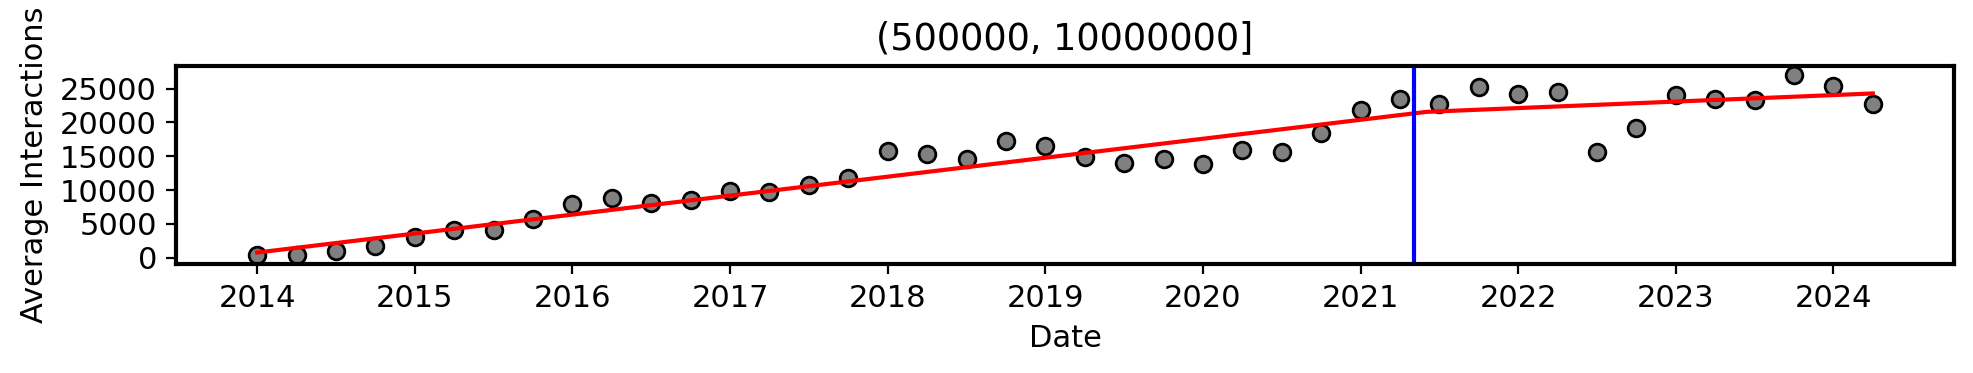

In [472]:
# fig, axs = plt.subplots(len(pivot_df.columns), figsize=(10, 6), sharex = True)

for col in pivot_df.columns:
    srwbp(pivot_df[col], fs=(10,2), title=col)
#     print(pivot_df[col])
#     print("----------------")
#     # # print(str(col) + "...")
#     # fig = plt.figure(figsize= (10,2))
#     # f = pivot_df[col]
#     # pw_fit = piecewise_regression.Fit(np.arange(f.shape[0]), np.array(f), n_breakpoints=1)
#     # # sum = pw_fit.summary()
    
#     # pw_fit.plot_data(color="grey", s=20, edgecolor= "black")
#     # # Pass in standard matplotlib keywords to control any of the plots
#     # pw_fit.plot_fit(color="red", linewidth=3)
#     # pw_fit.plot_breakpoints(color= 'blue')
#     # pw_fit.plot_breakpoint_confidence_intervals()
#     # plt.title(f"Segmented Regression for {col}")
#     # plt.ylabel("Average Interactions")
#     # plt.xlabel("Date")
#     # # print(fig.get_axes())
#     # fig.get_axes()[0].set_xticks(np.arange(f.shape[0]), minor=False, labels=f.index.year)
#     # # print(pd.date_range(f.iloc[0], f.iloc[-1], freq=date_freq).year)
#     # plt.locator_params(nbins=11)
#     # plt.tight_layout()
#     # plt.show()
    # srwbp(pivot_df[col], (10,2))
    

In [ ]:
# bp = pw_fit.get_results()["estimates"]["breakpoint1"]
# bp
# print("breakpoint estimate: " + f.iloc[int(np.ceil(bp["estimate"])),2].strftime("%Y-%m"))
# print("95% CI: [" + f.iloc[int(np.ceil(bp["confidence_interval"][0])),2].strftime("%Y-%m") + ", " + f.iloc[int(np.ceil(bp["confidence_interval"][1])),2].strftime("%Y-%m") + "]")
# Plot the data, fit, breakpoints and confidence intervals

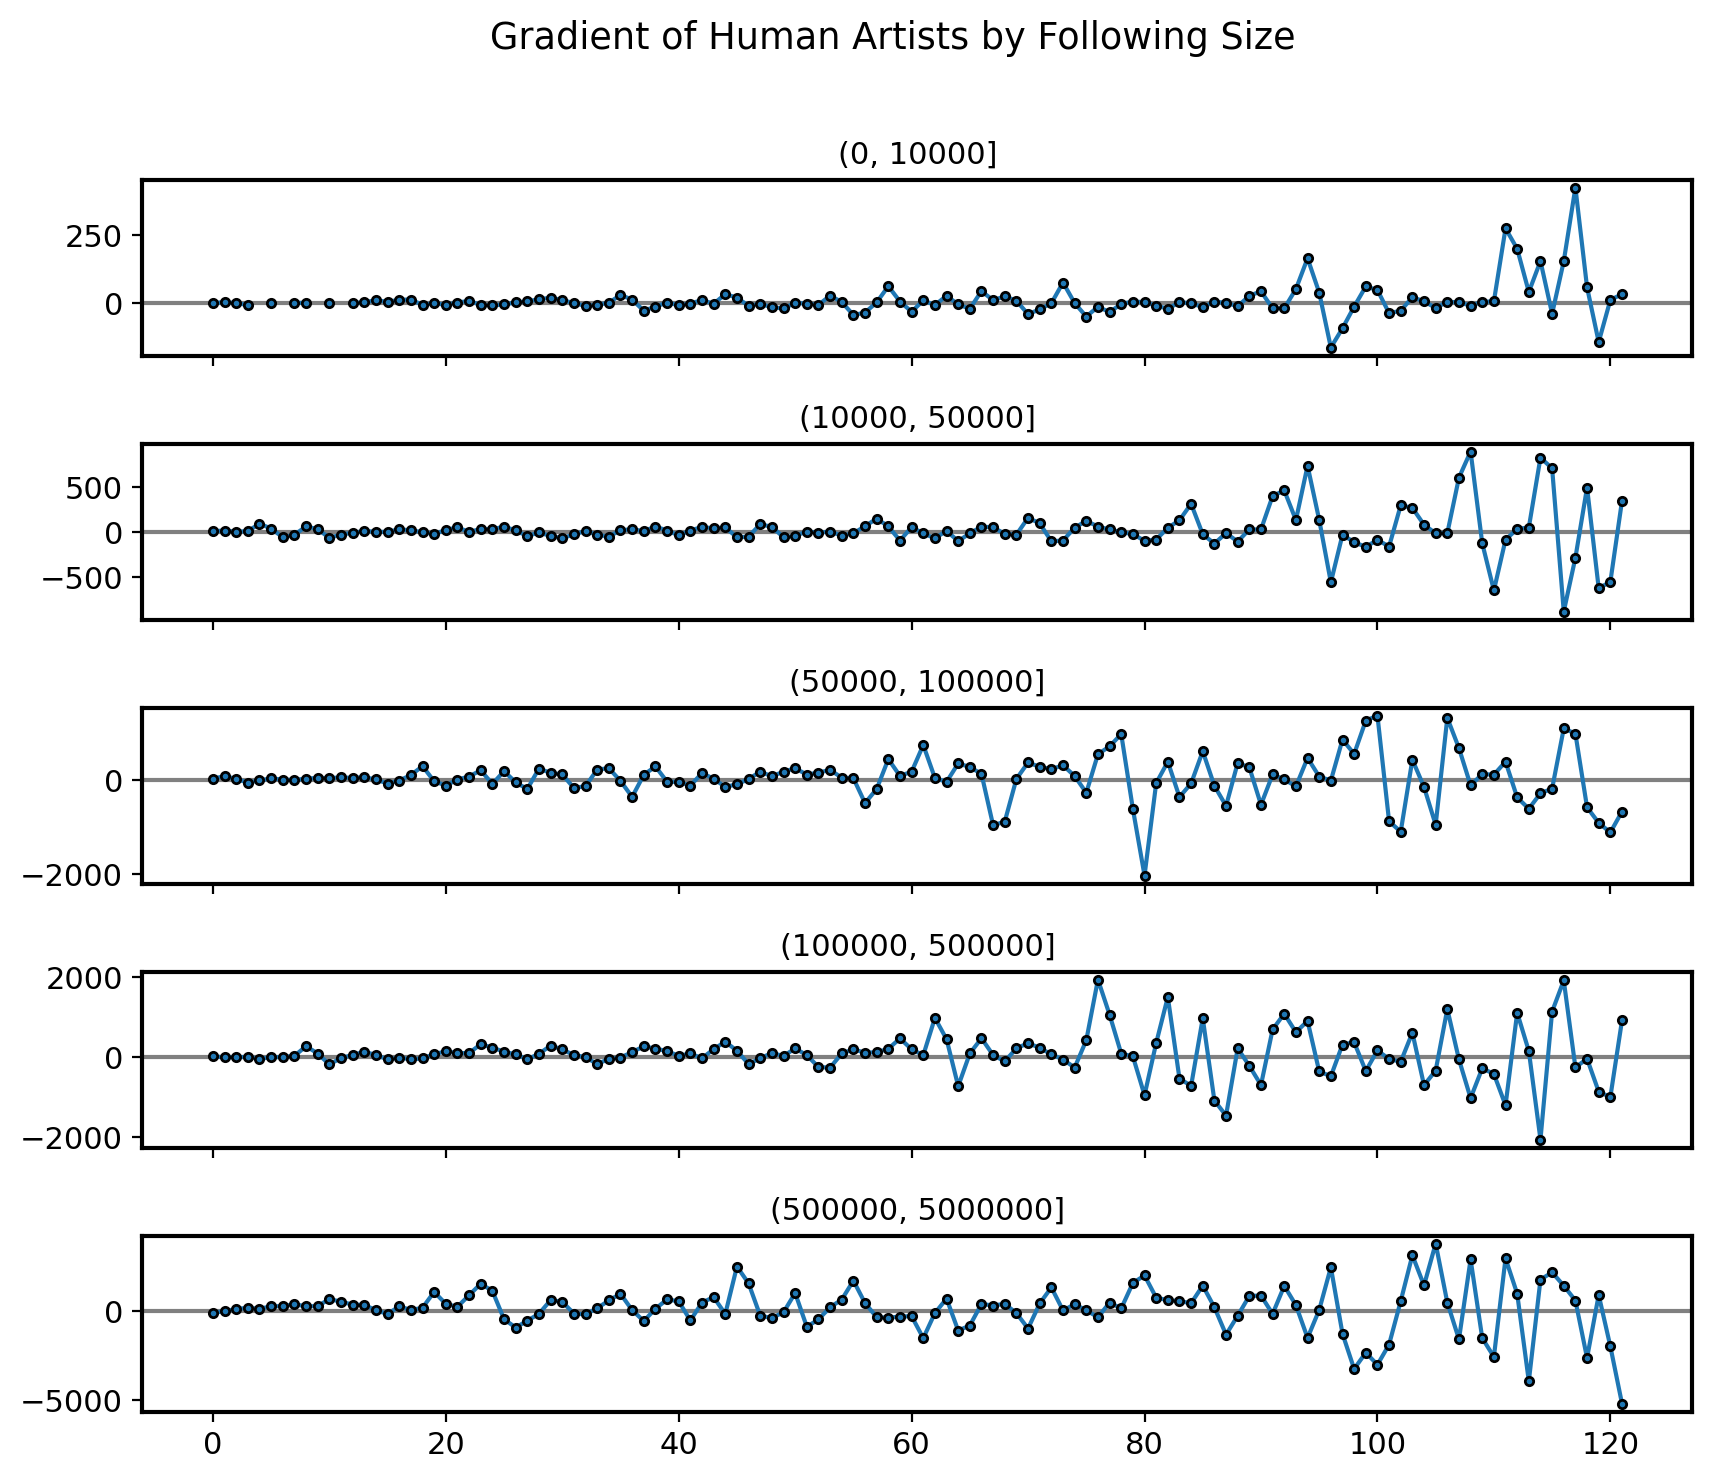

In [402]:
import itertools
fig, axs = plt.subplots(len(pivot_df.columns), sharex= True, figsize= (10,8))

for (col, ax) in zip(pivot_df.columns, axs):
    dfdx = np.gradient(pivot_df[col])
    ax.axhline(0, color='grey')
    ax.plot(pd.Series(dfdx), marker='o', markeredgecolor= 'black', markersize= 3)
    ax.set_title(col, fontsize= 11)
    
plt.suptitle("Gradient of Human Artists by Follower Size")
plt.subplots_adjust(hspace=0.5)

In [ ]:
pw_fit = piecewise_regression.Fit(np.array(f2.index), np.array(f2['ER']), n_breakpoints=1)

In [530]:
genres = np.intersect1d(ai_mdf["genre"].unique(), h_mdf["genre"].unique())

Anime


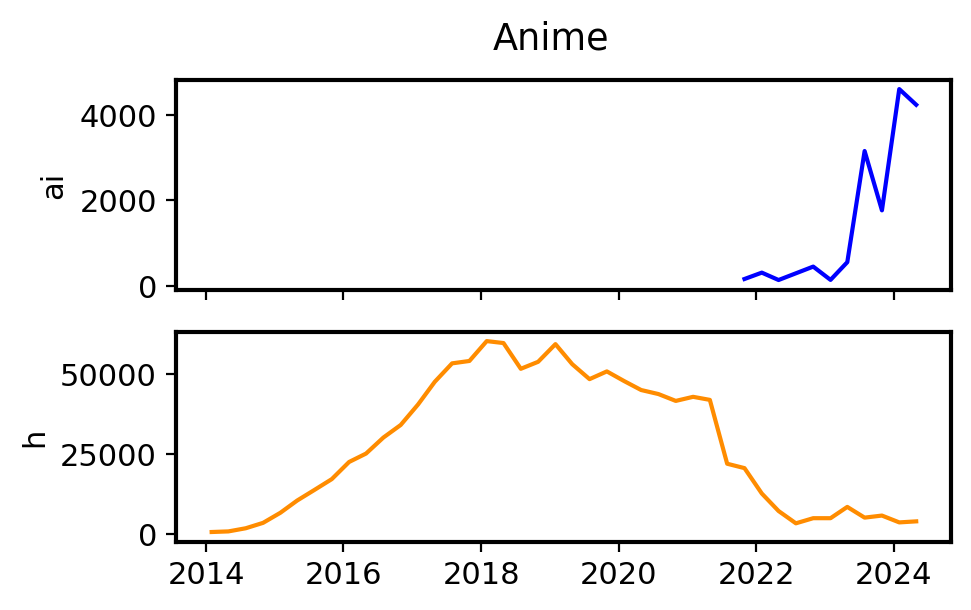

Character Design


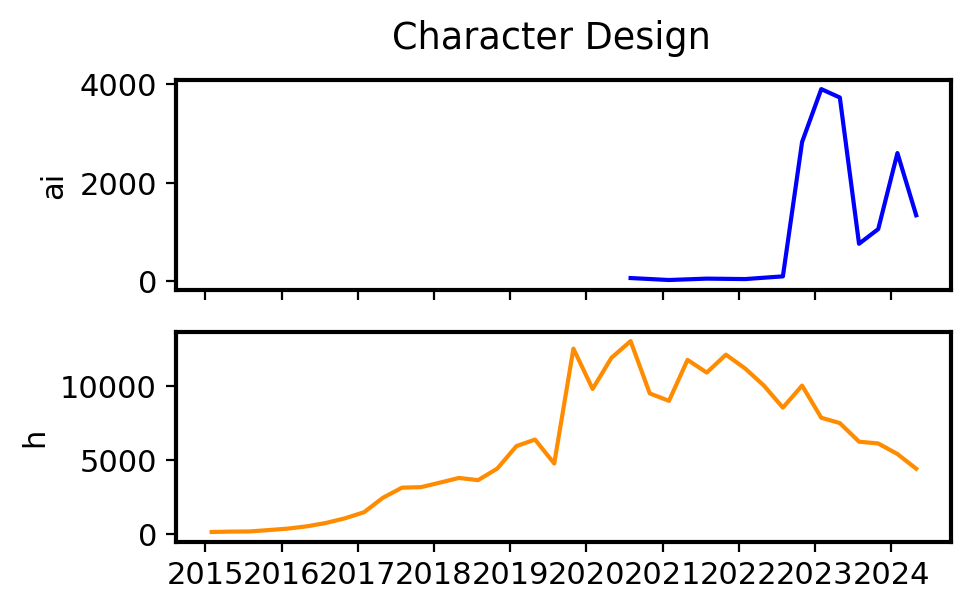

Environment/Landscape


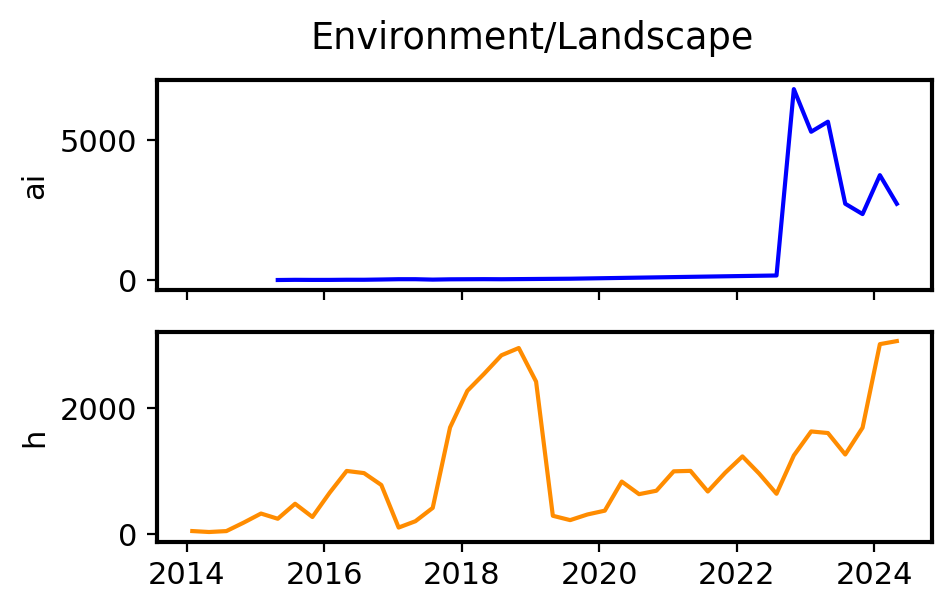

Fantasy


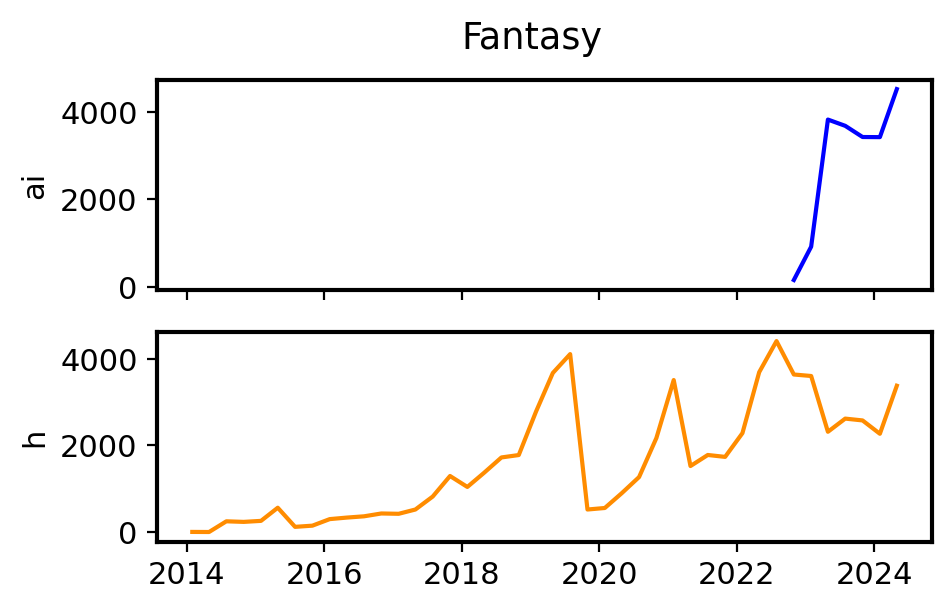

Fashion


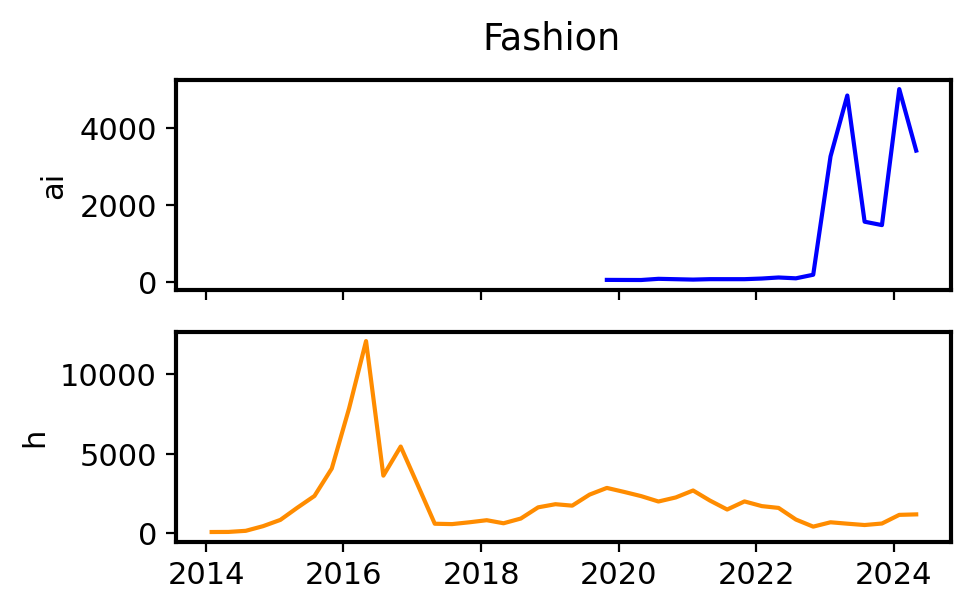

Horror


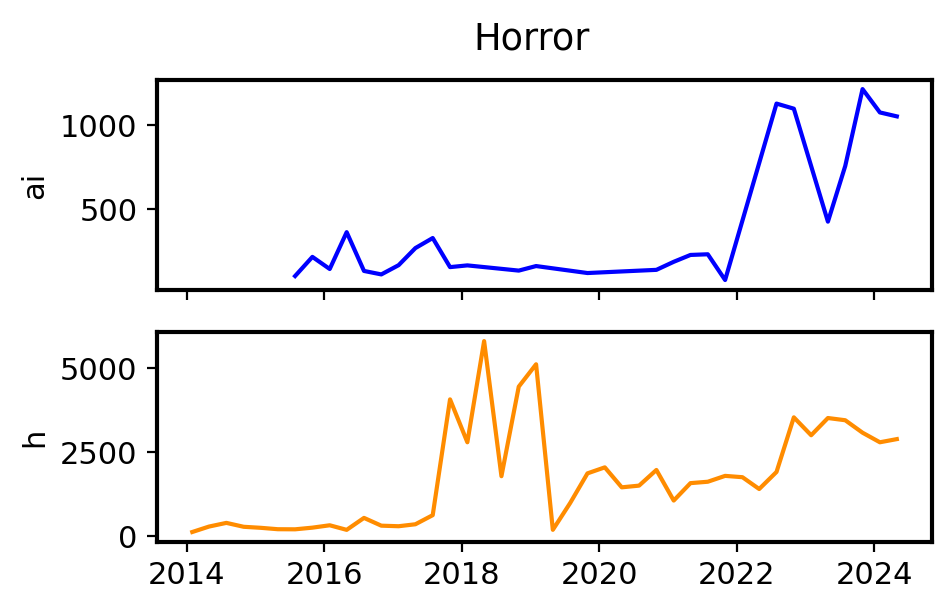

Mecha


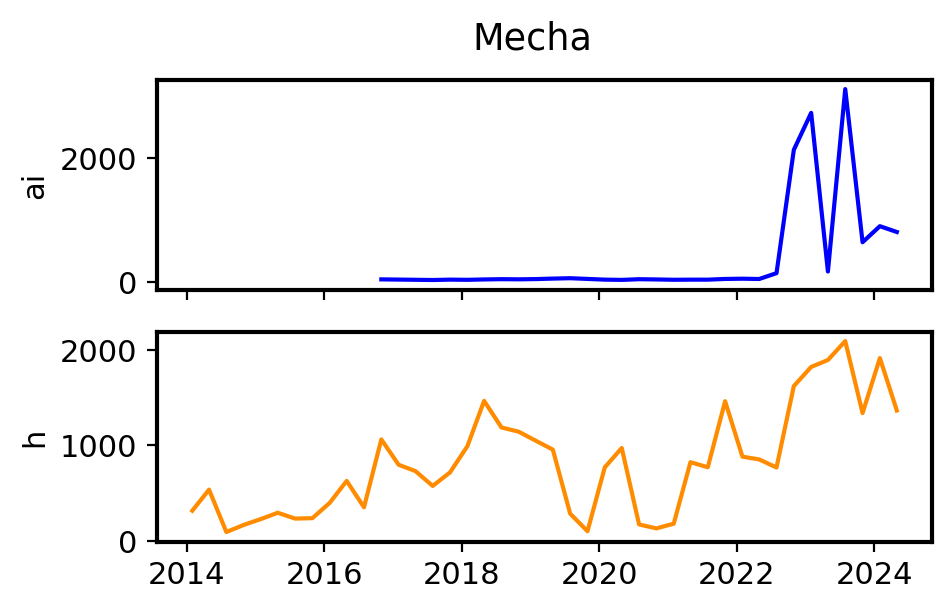

Portrait


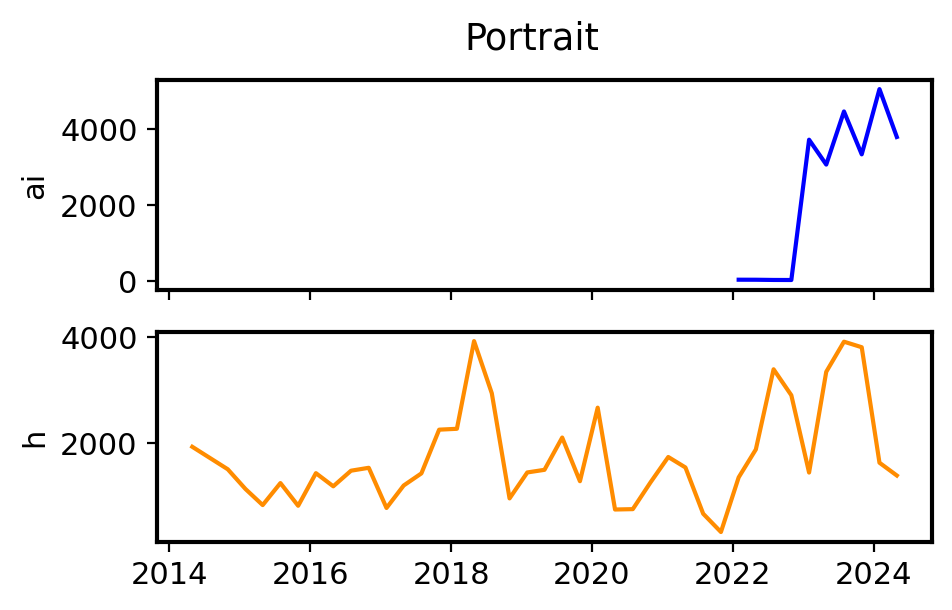

Semi Realism


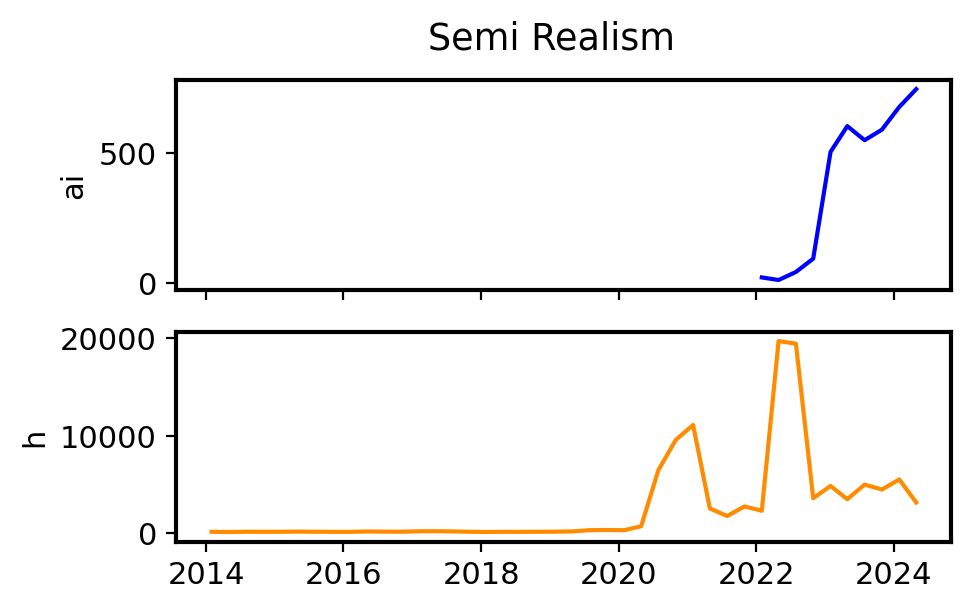

Stylized


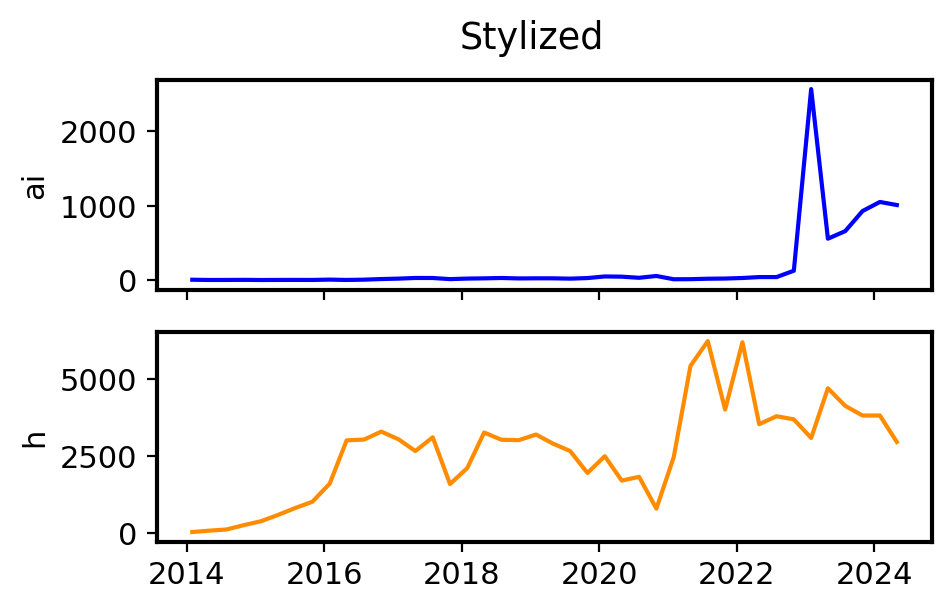

Traditional Painting


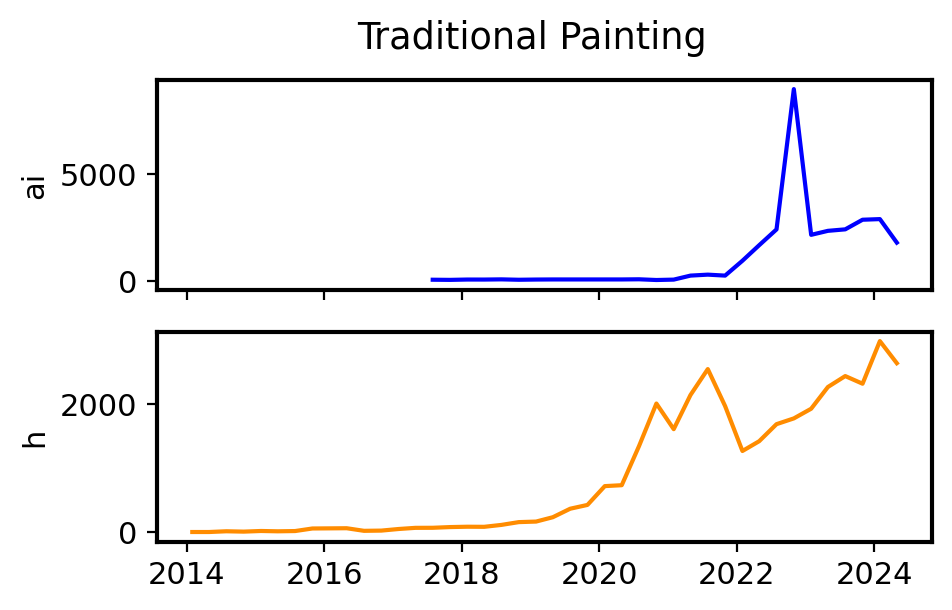

In [531]:
from operator import attrgetter
ai_avg_likes = ai_mdf.groupby(['genre', pd.Grouper(key='post_date', freq=date_freq)])['num_likes'].mean().reset_index()
h_avg_likes = h_mdf.groupby(['genre', pd.Grouper(key='post_date', freq=date_freq)])['num_likes'].median().reset_index()

since = pd.to_datetime("2013-1-1").to_period(date_freq)
for g in genres:
    print(g)
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(5,3))
    ai = ai_avg_likes[ai_avg_likes["genre"] == g]
    # ai["post_date"] = (ai["post_date"].dt.to_period(date_freq) - since).apply(attrgetter('n'))

    ax1.plot(ai["post_date"], ai["num_likes"], color= "blue")

    h = h_avg_likes[h_avg_likes["genre"] == g]
    # h["post_date"] = (h["post_date"].dt.to_period(date_freq) - since).apply(attrgetter('n'))
    # print(h)
    ax2.plot(h["post_date"], h["num_likes"], color="darkorange")
    ax1.set_ylabel("ai")
    ax2.set_ylabel("h")
    fig.suptitle(g)
    # fig.set_size(10,6)
    plt.show()

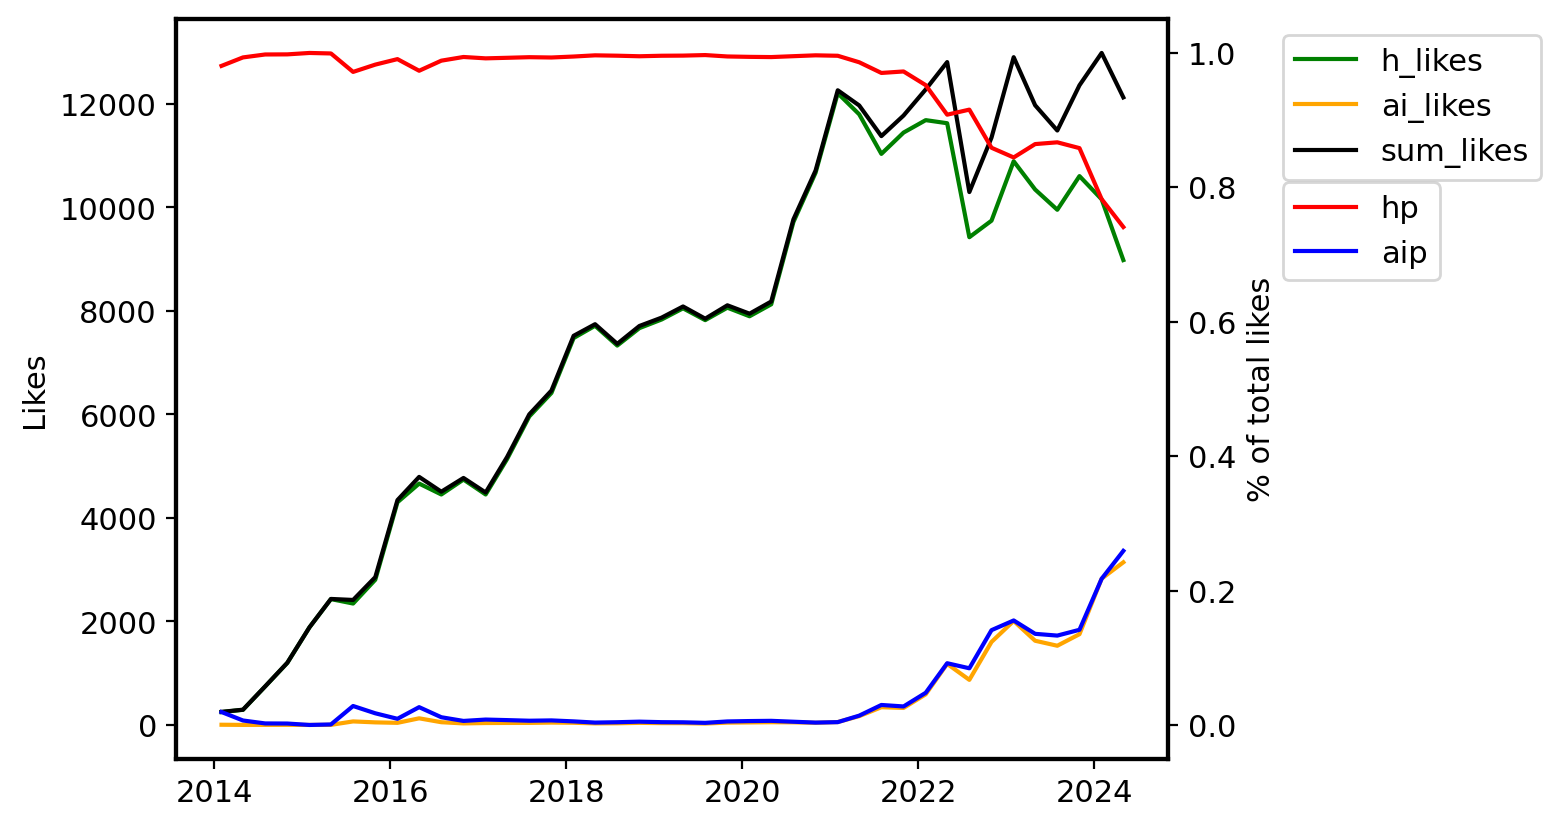

In [529]:

avg_likes = merged_dfe.groupby(['is_human_x', pd.Grouper(key='post_date', freq=date_freq)])['ER'].mean().reset_index()
pivot_df = avg_likes.pivot(index='post_date', columns='is_human_x', values='ER')
fig, ax = plt.subplots()
sum_likes = pivot_df[0] + pivot_df[1]
ax2 = ax.twinx()
ax.plot(pivot_df[1].index, pivot_df[1], color='green', label= "h_likes")
ax.plot(pivot_df[0].index, pivot_df[0], color='orange', label= "ai_likes")
ax.plot(pivot_df[0].index, sum_likes, color='black', label= "sum_likes")

ax2.plot(pivot_df[1].index, pivot_df[1]/sum_likes, color='red', label= "hp")
ax2.plot(pivot_df[0].index, pivot_df[0]/sum_likes, color='blue', label= "aip")
# ax.set_xlabel("Months since " + str(since))
ax.set_ylabel("Likes")
ax2.set_ylabel("% of total likes")#, rotation= 270)
ax.legend(loc='upper left', bbox_to_anchor=(1.1, 1))
ax2.legend(loc='upper left', bbox_to_anchor=(1.1, 0.8))